# EDA: EURUSD

Hola! :) 

En este notebook realizaremos un analisis exploratorio sobre el histórico del EURUSD. El objetivo de este analisis radica en crear las features iniciales para nuestro dataset y analizarlas para posteriormente modelar el problema con tecnicas de aprendizaje supervisado.

Para este caso modelaremos el problema de prediccion financiera como una tarea de clasificacion binaria, en donde los inputs seran distintos datos del estado actual del mercado (OHCL, indicadores + feature engineering) y el target sera una prediccion sobre la accion del precio (subirá o bajará) dentro de N periodos de tiempo.


Este dataset se encuentra en temporalidad H1 y cuenta con datos desde 2003-01-06 21:00:00 hasta 2020-12-08 23:00:00. El horario esta en formato UTC y fue descargado de la pagina de dukascopy: https://www.dukascopy.com/swiss/english/marketwatch/historical/

Comencemos!

In [1]:
import pandas as pd
pd.options.display.max_columns = None

from matplotlib import pyplot as plt
import talib
import numpy as np

In [2]:
eur_usd = pd.read_csv('./Data/EURUSD.csv')
eur_usd

,Gmt time,Open,High,Low,Close,Volume
0,04.05.2003 21:00:00.000,1.12354,1.12354,1.12279,1.12331,24206.599600
1,04.05.2003 22:00:00.000,1.12290,1.12317,1.12240,1.12251,23023.599600
2,04.05.2003 23:00:00.000,1.12255,1.12255,1.12176,1.12179,24839.699200
3,05.05.2003 00:00:00.000,1.12177,1.12318,1.12166,1.12274,23463.199200
4,05.05.2003 01:00:00.000,1.12242,1.12276,1.12119,1.12150,25406.599600
...,...,...,...,...,...,...
108023,18.08.2020 17:00:00.000,1.19364,1.19384,1.19299,1.19320,0.008529
108024,18.08.2020 18:00:00.000,1.19319,1.19389,1.19285,1.19382,0.004622
108025,18.08.2020 19:00:00.000,1.19382,1.19385,1.19306,1.19334,0.005943
108026,18.08.2020 20:00:00.000,1.19335,1.19384,1.19296,1.19317,0.002447


Para mayor comodidad renombraremos las columnas. Ademas, para evitar cualquier inconveniente, nos aseguraremos de que la data estara ordenada por la columna 'date' con formato año-mes-dia hora-minuto-segundo

In [3]:
eur_usd.rename(columns={'Gmt time' : 'date', 
                   'Open':'open',
                   'High':'high',
                   'Low':'low',
                   'Close':'close',
                   'Volume':'volume'}, inplace=True)

eur_usd["date"] = pd.to_datetime(eur_usd['date'])
eur_usd['date'] = pd.to_datetime(eur_usd['date'], format='%Y-%m-%d %H:%M:%S')
eur_usd.sort_values('date', inplace=True)
eur_usd.reset_index(inplace=True, drop=True)
eur_usd

,date,open,high,low,close,volume
0,2003-01-06 21:00:00,1.17149,1.17476,1.17115,1.17145,24919.8008
1,2003-01-06 22:00:00,1.17128,1.17181,1.17073,1.17133,22762.6992
2,2003-01-06 23:00:00,1.17154,1.17276,1.17107,1.17213,24167.3008
3,2003-01-07 00:00:00,1.15217,1.15281,1.15148,1.15185,24066.8008
4,2003-01-07 01:00:00,1.15214,1.15408,1.15180,1.15247,24589.4004
...,...,...,...,...,...,...
108023,2020-12-08 19:00:00,1.17842,1.17897,1.17828,1.17874,29280.2205
108024,2020-12-08 20:00:00,1.17874,1.17904,1.17844,1.17849,2165.6600
108025,2020-12-08 21:00:00,1.17850,1.17883,1.17808,1.17836,555.5914
108026,2020-12-08 22:00:00,1.17848,1.17910,1.17845,1.17882,1475.2500


Al plotear el precio de cierre, el grafico queda un poco "ruidoso" debido a la gran cantidad de datos que tenemos en nuestro dataset

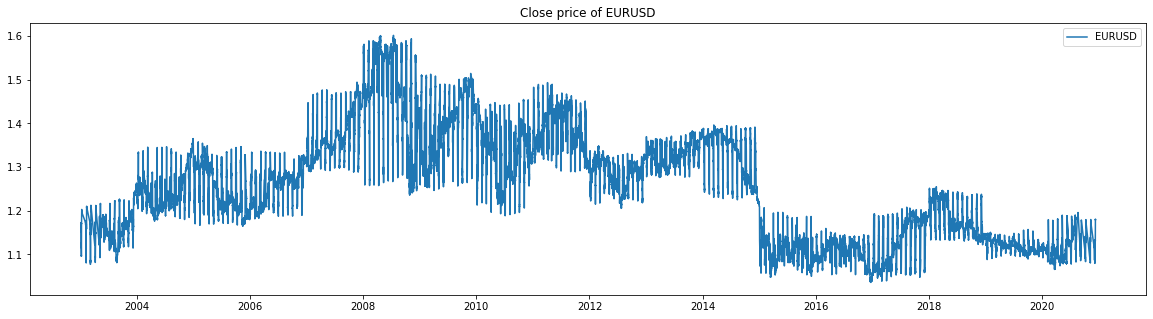

In [4]:
plt.figure(figsize=(20, 5))
plt.plot(eur_usd['date'], eur_usd['close'], label = 'EURUSD')
plt.title('Close price of EURUSD')
plt.legend(loc='best')
plt.show()

In [5]:
eur_usd.describe()

,open,high,low,close,volume
count,108028.000000,108028.000000,108028.000000,108028.000000,108028.000000
mean,1.258536,1.259577,1.257499,1.258539,21553.954875
std,0.122251,0.122421,0.122060,0.122250,33702.155079
min,1.035600,1.037040,1.034050,1.035630,0.000498
25%,1.142960,1.143880,1.142070,1.142950,5139.510050
50%,1.259450,1.260640,1.258255,1.259455,12194.800300
75%,1.345660,1.346690,1.344700,1.345640,25487.549800
max,1.601460,1.604030,1.598830,1.601570,491584.312500


In [6]:
eur_usd.isna().sum()

date      0
open      0
high      0
low       0
close     0
volume    0
dtype: int64

Con el objetivo de visualizar el grafico de una manera mas clara vamos a plotear la media movil de 200 periodos

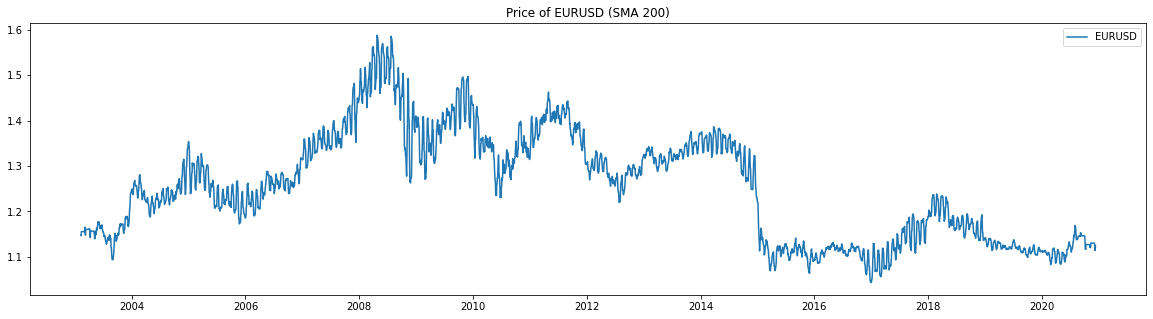

In [7]:
simple_ma_200 = talib.MA(eur_usd['close'], 200)
plt.figure(figsize=(20, 5))
plt.plot(eur_usd['date'], simple_ma_200, label='EURUSD')
plt.title('Price of EURUSD (SMA 200)')
plt.legend(loc='best')
plt.show()

In [8]:
del simple_ma_200

Por ultimo crearemos una funcion con los pasos anteriores ya que los necesitaremos a menudo.

In [9]:
def prepare_dataset(df, currency_name=None):
    df.rename(columns={'Gmt time' : 'date', 
                   'Open':'open',
                   'High':'high',
                   'Low':'low',
                   'Close':'close',
                   'Volume':'volume'}, inplace=True)

    df["date"] = pd.to_datetime(df['date'])
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
    df.sort_values('date', inplace=True)
    df.reset_index(inplace=True, drop=True)

## Features iniciales

Con ayuda de la librería TA-Lib crearemos las primeras features para nuestro dataset:

* Relative Strength Index
* Exponential Moving Average (12 periodos)
* Exponential Moving Average (26 periodos)
* Bollinger Bands
* Moving Average Convergence Divergence (MACD)
* Stochastic

Para el caso de RSI, MACD, Stochastic y Bollinger Bands utilizaremos los parametros estándar

In [10]:
eur_usd = pd.read_csv('./Data/EURUSD.csv')
prepare_dataset(eur_usd)

In [11]:
eur_usd["rsi"] = talib.RSI(eur_usd["close"], timeperiod=14)
eur_usd["ema_12"] = talib.EMA(eur_usd["close"], timeperiod=12)
eur_usd["ema_26"] = talib.EMA(eur_usd["close"], timeperiod=26) 

upper_band, middle_band, lower_band = talib.BBANDS(eur_usd["close"], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
eur_usd["upper_bband"] = upper_band
eur_usd["middle_bband"] = middle_band
eur_usd["lower_bband"] = lower_band

macd, macd_signal, macd_hist = talib.MACD(eur_usd["close"], fastperiod=12, slowperiod=26, signalperiod=9)
eur_usd["macd"] = macd 
eur_usd["macd_signal"] = macd_signal 
eur_usd["macd_hist"] = macd_hist

k, d = talib.STOCH(eur_usd["high"], eur_usd["low"], 
            eur_usd["close"], fastk_period=5, slowk_period=3, 
            slowk_matype=0, slowd_period=3, slowd_matype=0)

eur_usd["k"] = k
eur_usd["d"] = d
eur_usd

,date,open,high,low,close,volume,rsi,ema_12,ema_26,upper_bband,middle_bband,lower_bband,macd,macd_signal,macd_hist,k,d
0,2003-01-06 21:00:00,1.17149,1.17476,1.17115,1.17145,24919.8008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2003-01-06 22:00:00,1.17128,1.17181,1.17073,1.17133,22762.6992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2003-01-06 23:00:00,1.17154,1.17276,1.17107,1.17213,24167.3008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2003-01-07 00:00:00,1.15217,1.15281,1.15148,1.15185,24066.8008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2003-01-07 01:00:00,1.15214,1.15408,1.15180,1.15247,24589.4004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108023,2020-12-08 19:00:00,1.17842,1.17897,1.17828,1.17874,29280.2205,78.937377,1.176287,1.165333,1.182038,1.176044,1.170050,0.010954,0.012701,-0.001747,29.846018,41.673819
108024,2020-12-08 20:00:00,1.17874,1.17904,1.17844,1.17849,2165.6600,78.142057,1.176626,1.166308,1.182255,1.176297,1.170339,0.010318,0.012225,-0.001906,19.472684,30.183564
108025,2020-12-08 21:00:00,1.17850,1.17883,1.17808,1.17836,555.5914,77.703639,1.176893,1.167201,1.182384,1.176566,1.170749,0.009692,0.011718,-0.002026,16.220563,21.846422
108026,2020-12-08 22:00:00,1.17848,1.17910,1.17845,1.17882,1475.2500,78.170352,1.177189,1.168061,1.182415,1.176903,1.171392,0.009128,0.011200,-0.002072,24.560863,20.084703


In [12]:
eur_usd.isna().sum()

date             0
open             0
high             0
low              0
close            0
volume           0
rsi             14
ema_12          11
ema_26          25
upper_bband     19
middle_bband    19
lower_bband     19
macd            33
macd_signal     33
macd_hist       33
k                8
d                8
dtype: int64

Eliminamos nulos :)

In [13]:
eur_usd.dropna(inplace=True)
eur_usd.head(5)

,date,open,high,low,close,volume,rsi,ema_12,ema_26,upper_bband,middle_bband,lower_bband,macd,macd_signal,macd_hist,k,d
33,2003-01-08 06:00:00,1.12143,1.12219,1.11985,1.12063,24471.5996,13.641751,1.133053,1.142386,1.176656,1.144580,1.112504,-0.009378,-0.005336,-0.004042,32.469581,28.545903
34,2003-01-08 07:00:00,1.12014,1.12128,1.11957,1.12055,22474.8008,13.610761,1.131130,1.140769,1.176203,1.142864,1.109526,-0.009677,-0.006204,-0.003473,17.502664,26.063705
35,2003-01-08 08:00:00,1.12013,1.12087,1.11348,1.11525,21969.5996,11.712401,1.128687,1.138878,1.175844,1.140899,1.105954,-0.010224,-0.007008,-0.003216,18.059341,22.677195
36,2003-01-08 09:00:00,1.11550,1.11831,1.11479,1.11771,23376.6992,17.466413,1.126998,1.137310,1.174998,1.139130,1.103263,-0.010340,-0.007674,-0.002665,26.549553,20.703853
37,2003-01-08 10:00:00,1.11753,1.11838,1.11581,1.11620,22129.0000,16.745002,1.125337,1.135747,1.173573,1.137178,1.100784,-0.010433,-0.008226,-0.002207,30.125014,24.911303


### Exponential Moving Average (EMA)

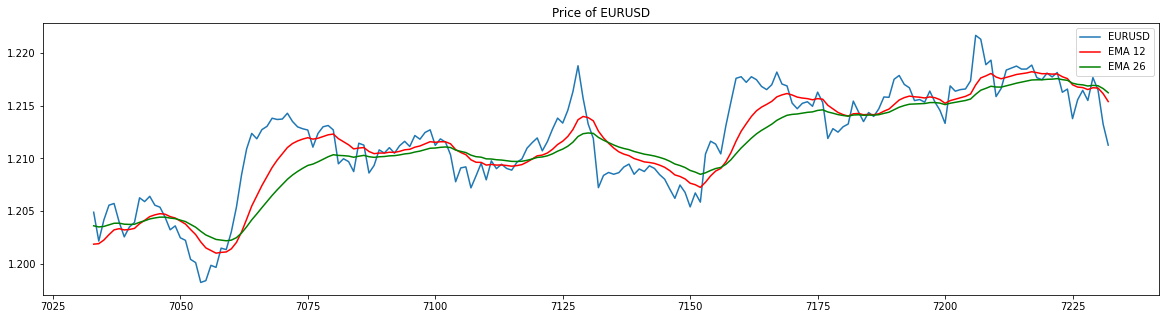

In [14]:
show_df = eur_usd[7000:7200]

plt.figure(figsize=(20, 5))
plt.plot(show_df.index, show_df['close'], label='EURUSD')
plt.plot(show_df.index, show_df['ema_12'], c='r', label='EMA 12')
plt.plot(show_df.index, show_df['ema_26'], c='g', label='EMA 26')

plt.title('Price of EURUSD')
plt.legend(loc='best')
plt.show()

### Bollinger Bands

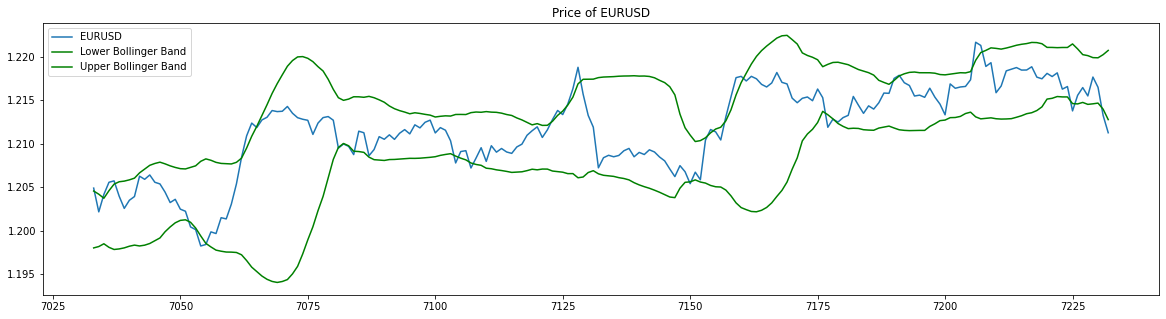

In [15]:
plt.figure(figsize=(20, 5))
plt.plot(show_df.index, show_df['close'], label='EURUSD')
plt.plot(show_df.index, show_df['lower_bband'], c='g', label='Lower Bollinger Band')
plt.plot(show_df.index, show_df['upper_bband'], c='g', label='Upper Bollinger Band')

plt.title('Price of EURUSD')
plt.legend(loc='best')
plt.show()

### Relative Strength Index

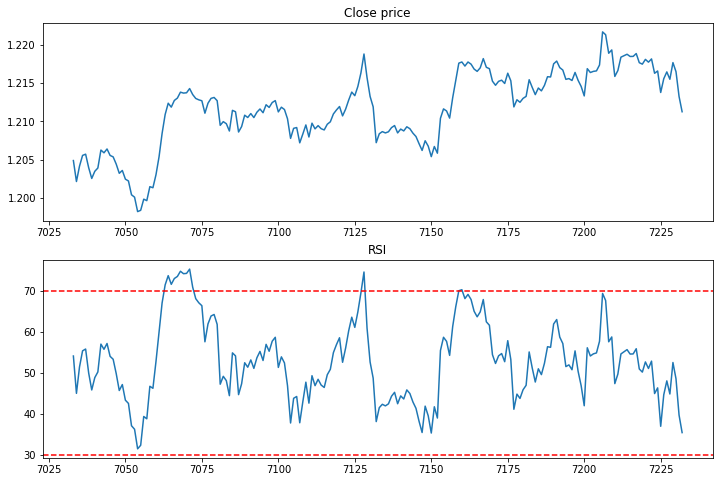

In [16]:
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(show_df.close.index, show_df.close)
plt.title('Close price')

plt.subplot(2,1,2)
plt.plot(show_df.rsi.index, show_df.rsi)
plt.title('RSI')
plt.axhline(70, c='r', linestyle='--')
plt.axhline(30, c='r', linestyle='--')

plt.show()

### MACD

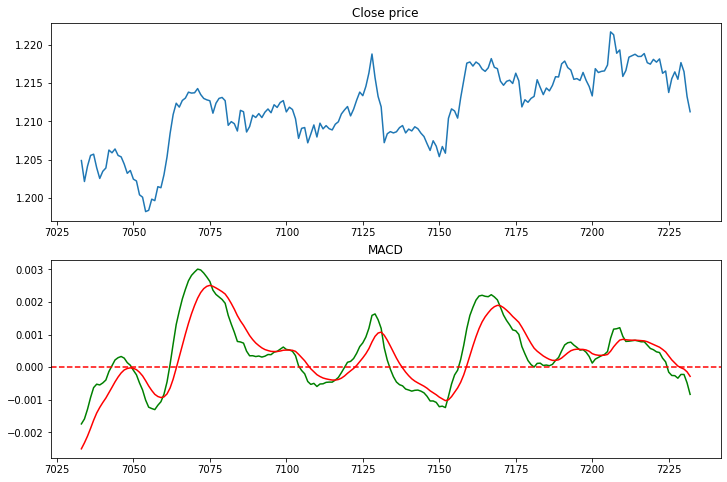

In [17]:
plt.figure(figsize=(12,8))

plt.subplot(2,1,1)
plt.plot(show_df.index, show_df.close)
plt.title('Close price')

plt.subplot(2,1,2)
plt.plot(show_df.index, show_df.macd, c='g')
plt.plot(show_df.index, show_df.macd_signal, c='r')
plt.title('MACD')

plt.axhline(0, c='r', linestyle='--')
plt.show()

### Stochastic

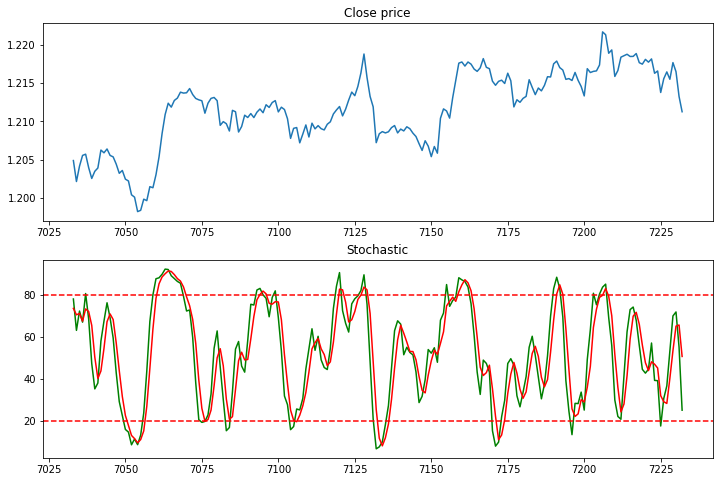

In [18]:
plt.figure(figsize=(12,8))

plt.subplot(2,1,1)
plt.plot(show_df.index, show_df.close)
plt.title('Close price')

plt.subplot(2,1,2)
plt.plot(show_df.index, show_df.k, c='g')
plt.plot(show_df.index, show_df.d, c='r')
plt.title('Stochastic')

plt.axhline(20, c='r', linestyle='--')
plt.axhline(80, c='r', linestyle='--')

plt.show()

In [19]:
def get_all_indicators(dataframe):
    df = dataframe.copy()    
    df["rsi"] = talib.RSI(df["close"], timeperiod=14)
    df["ema_12"] = talib.EMA(df["close"], timeperiod=12)
    df["ema_26"] = talib.EMA(df["close"], timeperiod=26) 

    upper_band, middle_band, lower_band = talib.BBANDS(df["close"], timeperiod=20, 
                                                nbdevup=2, nbdevdn=2, matype=0)

    df["upper_bband"] = upper_band
    df["middle_bband"] = middle_band
    df["lower_bband"] = lower_band


    macd, macd_signal, macd_hist = talib.MACD(df["close"], fastperiod=12, slowperiod=26, 
                                        signalperiod=9)

    df["macd"] = macd 
    df["macd_signal"] = macd_signal 
    df["macd_hist"] = macd_hist
    
    k, d = talib.STOCH(df["high"], df["low"], df["close"], fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)

    df["k"] = k
    df["d"] = d
    
    return df

## Target

Te acordás cuando al inicio dijimos: "el target será una predicción sobre la acción del precio (subirá o bajará) dentro de N periodos de tiempo."? Bien, es momento de definir ese N.

-Pero... ¿Cuantas horas hacia el futuro vamos a predecir? ¿una?, ¿dos?, ¿Por que una o por que dos?.

Vamos por partes... Nuestro problema tiene dos clases posibles: "subirá" o "bajá" (de ahora en mas 1 y 0) y nosotros intentaremos predecir esos 1 y 0 a partir de las condiciones actuales del mercado.

-¿Condiciones actuales del mercado?

Si, las condiciones actuales (o estado actual) del mercado nos vienen dadas por los valores de nuestros indicadores financieros!. En base a esto crearemos un dataframe en el cual para cada fila tendremos en el valor de nuestros indicadores i1, i2, ... in correspondientes al tiempo t, y un target que indica que sucederá con el precio en el tiempo t+n!

[i11, i12, ..., i1n] --> 1

[i21, i22, ..., i2n] --> 0

...

[in1, in2, ..., inn] --> 1


-Bien, entonces... ¿Cuanto valdrá N?

Segun mi opinión, N deberia tener un valor que haga que la distribucion de los indicadores entre targets 0 y 1 sea lo mas diferente posible. 

-¿ :) ? 

Bueno, quiero decir que si distintas configuraciones de indicadores generan como resultado velas alcistas y/o bajistas, deberiamos buscar un N que haga estas configuraciones tan evidentes como sea posible (al menos para los modelos de ML).

Comencemos simplemente calculando el target una hora hacia el futuro:

In [20]:
eur_usd = pd.read_csv('./Data/EURUSD.csv')
prepare_dataset(eur_usd)

eur_usd["date"] = pd.to_datetime(eur_usd['date'])
eur_usd['date'] = pd.to_datetime(eur_usd['date'], format='%Y-%m-%d %H:%M:%S')
eur_usd.sort_values('date', inplace=True)
eur_usd.reset_index(inplace=True, drop=True)

eur_usd = get_all_indicators(eur_usd)
eur_usd.dropna(inplace=True)

In [21]:
eur_usd['target'] = np.where(eur_usd['close'].shift(-1) > eur_usd['close'], 1, 0)
eur_usd

,date,open,high,low,close,volume,rsi,ema_12,ema_26,upper_bband,middle_bband,lower_bband,macd,macd_signal,macd_hist,k,d,target
33,2003-01-08 06:00:00,1.12143,1.12219,1.11985,1.12063,24471.5996,13.641751,1.133053,1.142386,1.176656,1.144580,1.112504,-0.009378,-0.005336,-0.004042,32.469581,28.545903,0
34,2003-01-08 07:00:00,1.12014,1.12128,1.11957,1.12055,22474.8008,13.610761,1.131130,1.140769,1.176203,1.142864,1.109526,-0.009677,-0.006204,-0.003473,17.502664,26.063705,0
35,2003-01-08 08:00:00,1.12013,1.12087,1.11348,1.11525,21969.5996,11.712401,1.128687,1.138878,1.175844,1.140899,1.105954,-0.010224,-0.007008,-0.003216,18.059341,22.677195,1
36,2003-01-08 09:00:00,1.11550,1.11831,1.11479,1.11771,23376.6992,17.466413,1.126998,1.137310,1.174998,1.139130,1.103263,-0.010340,-0.007674,-0.002665,26.549553,20.703853,0
37,2003-01-08 10:00:00,1.11753,1.11838,1.11581,1.11620,22129.0000,16.745002,1.125337,1.135747,1.173573,1.137178,1.100784,-0.010433,-0.008226,-0.002207,30.125014,24.911303,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108023,2020-12-08 19:00:00,1.17842,1.17897,1.17828,1.17874,29280.2205,78.937377,1.176287,1.165333,1.182038,1.176044,1.170050,0.010954,0.012701,-0.001747,29.846018,41.673819,0
108024,2020-12-08 20:00:00,1.17874,1.17904,1.17844,1.17849,2165.6600,78.142057,1.176626,1.166308,1.182255,1.176297,1.170339,0.010318,0.012225,-0.001906,19.472684,30.183564,0
108025,2020-12-08 21:00:00,1.17850,1.17883,1.17808,1.17836,555.5914,77.703639,1.176893,1.167201,1.182384,1.176566,1.170749,0.009692,0.011718,-0.002026,16.220563,21.846422,1
108026,2020-12-08 22:00:00,1.17848,1.17910,1.17845,1.17882,1475.2500,78.170352,1.177189,1.168061,1.182415,1.176903,1.171392,0.009128,0.011200,-0.002072,24.560863,20.084703,1


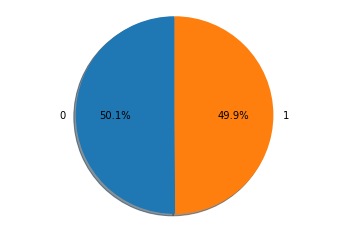

In [22]:
labels = eur_usd.target.unique()
sizes = eur_usd.target.value_counts().values
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

El target se encuentra balanceado dentro de nuestro dataset.

In [23]:
def create_target(close, periods_fordward):
    return np.where(close.shift(-periods_fordward) > close, 1, 0)

## Feature engineering

Creemos tambien algunas features adicionales que nos ayudaran a capturar datos de intéres sobre los indicadores:

* Discretizacion de los valores del RSI

In [24]:
cut_labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
cut_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
eur_usd['discrete_rsi'] = pd.cut(eur_usd['rsi'], bins=cut_bins, labels=cut_labels)

* ¿El precio de cierre es mayor a la EMA de 12 periodos?

In [25]:
eur_usd['discrete_ema_12'] = np.where(eur_usd['close'] > eur_usd['ema_12'], 1, 0)

* ¿El precio de cierre es mayor a la EMA de 26 periodos?

In [26]:
eur_usd['discrete_ema_26'] = np.where(eur_usd['close'] > eur_usd['ema_26'], 1, 0)

* ¿La EMA de 12 periodos es mayor a la de 26?

In [27]:
eur_usd['discrete_ema12_ema26'] = np.where(eur_usd['ema_12'] > eur_usd['ema_26'], 1, 0)

* ¿El precio de cierre es mayor a la banda de Bollinger superior o menor a la inferior?

In [28]:
eur_usd['discrete_bollinger_bands'] = 0
eur_usd.loc[eur_usd.close > eur_usd.upper_bband, 'discrete_bollinger_bands'] = 1
eur_usd.loc[eur_usd.close < eur_usd.lower_bband, 'discrete_bollinger_bands'] = -1

* Creamos indicador %B y lo discretizamos

In [29]:
eur_usd['b_percentage'] = round((eur_usd.close - eur_usd.lower_bband) / (eur_usd.upper_bband - eur_usd.lower_bband)*100)

* ¿La señal de MACD es mayor a 0?

In [30]:
eur_usd['discrete_macd_signal'] = np.where(eur_usd['macd_signal'] > 0, 1, 0)

* ¿El histograma de MACD es mayor a 0?

In [31]:
eur_usd['discrete_macd_hist'] = np.where(eur_usd['macd_hist'] > 0, 1, 0)

* ¿La señal de MACD es mayor al histograma?

In [32]:
eur_usd['discrete_macd_signal_hist'] = np.where(eur_usd['macd_signal'] > eur_usd['macd_hist'], 1, 0)

Discretizacion de los valores del Estocástico

In [33]:
eur_usd['discrete_stochastic'] = pd.cut(eur_usd['rsi'], bins=cut_bins, labels=cut_labels)

* ¿Es K mayor a D?

In [34]:
eur_usd['discrete_kd'] = np.where(eur_usd['k'] > eur_usd['d'], 1, 0)

Por ultimo vamos a reordenar las columnas

In [35]:
eur_usd.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'rsi', 'ema_12',
       'ema_26', 'upper_bband', 'middle_bband', 'lower_bband', 'macd',
       'macd_signal', 'macd_hist', 'k', 'd', 'target', 'discrete_rsi',
       'discrete_ema_12', 'discrete_ema_26', 'discrete_ema12_ema26',
       'discrete_bollinger_bands', 'b_percentage', 'discrete_macd_signal',
       'discrete_macd_hist', 'discrete_macd_signal_hist',
       'discrete_stochastic', 'discrete_kd'],
      dtype='object')

In [36]:
cols = ['date', 'open', 'high', 'low', 'close', 'volume', 'rsi', 'discrete_rsi', 'ema_12', 'discrete_ema_12',
       'ema_26', 'discrete_ema_26', 'discrete_ema12_ema26','upper_bband', 'middle_bband', 'lower_bband',
        'discrete_bollinger_bands', 'b_percentage', 'macd', 'macd_signal', 
        'discrete_macd_signal', 'macd_hist', 'discrete_macd_hist', 'discrete_macd_signal_hist','k', 'd', 
        'discrete_kd', 'discrete_stochastic', 'target']

eur_usd = eur_usd[cols]

In [37]:
eur_usd.describe()

,open,high,low,close,volume,rsi,ema_12,discrete_ema_12,ema_26,discrete_ema_26,discrete_ema12_ema26,upper_bband,middle_bband,lower_bband,discrete_bollinger_bands,b_percentage,macd,macd_signal,discrete_macd_signal,macd_hist,discrete_macd_hist,discrete_macd_signal_hist,k,d,discrete_kd,target
count,107995.000000,107995.000000,107995.000000,107995.000000,107995.000000,107995.000000,107995.000000,107995.000000,107995.000000,107995.000000,107995.000000,107995.000000,107995.000000,107995.000000,107995.000000,107995.0,1.079950e+05,1.079950e+05,107995.000000,1.079950e+05,107995.000000,107995.000000,107995.000000,107995.000000,107995.000000,107995.000000
mean,1.258569,1.259610,1.257532,1.258572,21548.850811,50.144125,1.258569,0.505533,1.258569,0.502570,0.504283,1.272443,1.258568,1.244693,0.001537,inf,7.148311e-07,1.588243e-07,0.504940,5.560068e-07,0.503736,0.504190,50.221088,50.220958,0.500579,0.500903
std,0.122255,0.122425,0.122064,0.122254,33697.468081,19.010186,0.121631,0.499972,0.120943,0.499996,0.499984,0.126181,0.121556,0.120883,0.373479,NaN,7.839716e-03,7.331804e-03,0.499978,2.482300e-03,0.499988,0.499985,24.897348,23.050310,0.500002,0.500001
min,1.035600,1.037040,1.034050,1.035630,0.000498,0.941153,1.038245,0.000000,1.039462,0.000000,0.000000,1.040530,1.038541,0.968028,-1.000000,-59.0,-6.053900e-02,-5.328549e-02,0.000000,-2.790402e-02,0.000000,0.000000,0.118809,0.490922,0.000000,0.000000
25%,1.142940,1.143880,1.142065,1.142920,5136.510000,36.904425,1.142914,0.000000,1.142889,0.000000,0.000000,1.158821,1.143217,1.134258,0.000000,24.0,-1.886138e-03,-1.804566e-03,0.000000,-5.128058e-04,0.000000,0.000000,29.514499,31.291580,0.000000,0.000000
50%,1.259470,1.260740,1.258330,1.259480,12188.849600,50.134006,1.259980,1.000000,1.260754,1.000000,1.000000,1.273631,1.260045,1.241778,0.000000,51.0,2.262768e-05,2.493186e-05,1.000000,5.962255e-06,1.000000,1.000000,50.387093,50.442547,1.000000,1.000000
75%,1.345680,1.346700,1.344720,1.345660,25488.500000,63.225275,1.345912,1.000000,1.345955,1.000000,1.000000,1.361194,1.345915,1.331395,0.000000,76.0,1.894578e-03,1.831014e-03,1.000000,5.068078e-04,1.000000,1.000000,70.967930,69.211890,1.000000,1.000000
max,1.601460,1.604030,1.598830,1.601570,491584.312500,97.512051,1.597993,1.000000,1.596321,1.000000,1.000000,1.783772,1.598240,1.595647,1.000000,inf,8.021493e-02,7.098380e-02,1.000000,4.233696e-02,1.000000,1.000000,99.926625,99.511453,1.000000,1.000000


Luego de hacer el describe me llamo la antencion el hecho de que la media y el maximo del indicador %B sea infinito. Luego de indagar un poco me di cuenta de que ese numero era resultado de algunas divisiones por 0 al momento del calculo del indicador. Veamos cuantas filas tienen este valor dentro de nuestro dataset

In [38]:
import math
len(eur_usd.loc[eur_usd.b_percentage == math.inf])

14

In [39]:
eur_usd = eur_usd.drop(eur_usd[eur_usd.b_percentage == math.inf].index)

Al ser solo 14 podemos eliminar estos valores sin que esto represente un problema.

In [40]:
eur_usd.describe()

,open,high,low,close,volume,rsi,ema_12,discrete_ema_12,ema_26,discrete_ema_26,discrete_ema12_ema26,upper_bband,middle_bband,lower_bband,discrete_bollinger_bands,b_percentage,macd,macd_signal,discrete_macd_signal,macd_hist,discrete_macd_hist,discrete_macd_signal_hist,k,d,discrete_kd,target
count,107981.000000,107981.000000,107981.000000,107981.000000,107981.000000,107981.000000,107981.000000,107981.000000,107981.000000,107981.000000,107981.000000,107981.000000,107981.000000,107981.000000,107981.000000,107981.000000,1.079810e+05,1.079810e+05,107981.000000,1.079810e+05,107981.000000,107981.000000,107981.000000,107981.000000,107981.000000,107981.000000
mean,1.258556,1.259597,1.257519,1.258558,21548.775368,50.143496,1.258556,0.505496,1.258555,0.502533,0.504246,1.272432,1.258555,1.244678,0.001408,50.332697,8.007949e-07,2.556867e-07,0.504904,5.451082e-07,0.503774,0.504154,50.221984,50.222360,0.500542,0.500921
std,0.122253,0.122423,0.122062,0.122252,33698.663350,19.009929,0.121628,0.499972,0.120941,0.499996,0.499984,0.126180,0.121554,0.120880,0.373331,35.562465,7.840184e-03,7.332217e-03,0.499978,2.482456e-03,0.499988,0.499985,24.898226,23.050846,0.500002,0.500001
min,1.035600,1.037040,1.034050,1.035630,0.000498,0.941153,1.038245,0.000000,1.039462,0.000000,0.000000,1.040530,1.038541,0.968028,-1.000000,-59.000000,-6.053900e-02,-5.328549e-02,0.000000,-2.790402e-02,0.000000,0.000000,0.118809,0.490922,0.000000,0.000000
25%,1.142920,1.143870,1.142030,1.142920,5136.279800,36.903489,1.142904,0.000000,1.142870,0.000000,0.000000,1.158792,1.143203,1.134250,0.000000,24.000000,-1.886182e-03,-1.804612e-03,0.000000,-5.130668e-04,0.000000,0.000000,29.514828,31.292490,0.000000,0.000000
50%,1.259470,1.260710,1.258310,1.259480,12188.440400,50.132245,1.259955,1.000000,1.260740,1.000000,1.000000,1.273611,1.260028,1.241772,0.000000,51.000000,2.236457e-05,2.472232e-05,1.000000,5.998702e-06,1.000000,1.000000,50.388941,50.445936,1.000000,1.000000
75%,1.345660,1.346690,1.344700,1.345640,25488.500000,63.224162,1.345883,1.000000,1.345929,1.000000,1.000000,1.361183,1.345894,1.331379,0.000000,76.000000,1.894896e-03,1.831393e-03,1.000000,5.068097e-04,1.000000,1.000000,70.971322,69.213444,1.000000,1.000000
max,1.601460,1.604030,1.598830,1.601570,491584.312500,97.512051,1.597993,1.000000,1.596321,1.000000,1.000000,1.783772,1.598240,1.595647,1.000000,159.000000,8.021493e-02,7.098380e-02,1.000000,4.233696e-02,1.000000,1.000000,99.926625,99.511453,1.000000,1.000000


## Analizando distribuciones

In [41]:
group_by_target = eur_usd.groupby(by=['target'])
mean = group_by_target.mean()
std = group_by_target.std()

continous_cols = ['rsi', 'ema_12', 'ema_26', 'upper_bband', 'middle_bband','lower_bband', 'b_percentage', 'macd', 'macd_signal', 
                  'macd_hist', 'k', 'd'] 
display(mean[continous_cols])
display(std[continous_cols])

,rsi,ema_12,ema_26,upper_bband,middle_bband,lower_bband,b_percentage,macd,macd_signal,macd_hist,k,d
target,,,,,,,,,,,,
0,50.620909,1.258684,1.258638,1.272526,1.258645,1.244764,51.572025,0.000045,0.000033,0.000012,51.201040,50.835654
1,49.667841,1.258429,1.258473,1.272338,1.258465,1.244592,49.097929,-0.000043,-0.000032,-0.000011,49.246531,49.611322


,rsi,ema_12,ema_26,upper_bband,middle_bband,lower_bband,b_percentage,macd,macd_signal,macd_hist,k,d
target,,,,,,,,,,,,
0,18.987918,0.121410,0.120770,0.125976,0.121373,0.120738,35.443058,0.007864,0.007383,0.002471,24.890399,23.004459
1,19.020095,0.121846,0.121113,0.126385,0.121734,0.121022,35.638527,0.007817,0.007281,0.002494,24.867947,23.080982


Vemos que tanto las medias como los desvios de  nuestras variables continuas son practicamente iguales! Al menos a simple vita, no hay nada en los indicadores que nos pueda ayudar a diferenciar un target de otro. Sigamos analizando...

### Discrete RSI

In [42]:
from scipy.spatial import distance
from scipy.stats import wasserstein_distance

,discrete_rsi,target,count
0,1,0,695
1,1,1,758
2,2,0,2556
3,2,1,2702
4,3,0,4825
5,3,1,5169
6,4,0,7632
7,4,1,8210
8,5,0,10356
9,5,1,10792


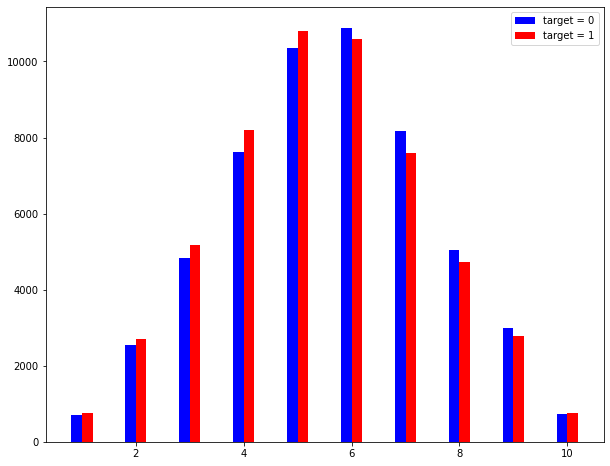

wasserstein distance:  0.09625342944607501


In [50]:
target_counts = pd.DataFrame({'count' : eur_usd.groupby( [ "discrete_rsi", "target"] ).size()}).reset_index()

x = np.sort(eur_usd.discrete_rsi.unique())
y = target_counts.loc[target_counts['target'] == 0]['count'].values
z = target_counts.loc[target_counts['target'] == 1]['count'].values

display(target_counts)


plt.figure(figsize=(10, 8))
ax = plt.subplot(111)
ax.bar(x-0.1, y, width=0.2, color='b', align='center', label='target = 0')
ax.bar(x+0.1, z, width=0.2, color='r', align='center', label='target = 1')
plt.legend(loc='best')

plt.show()


eur_usd_bearish = eur_usd.loc[eur_usd.target == 0]
eur_usd_bullish = eur_usd.loc[eur_usd.target == 1]

dist = wasserstein_distance(eur_usd_bearish['discrete_rsi'], eur_usd_bullish['discrete_rsi'])
print('wasserstein distance: ', dist)

En lo que respecta a la version discreta de nuestro RSI notamos los valores menores a 50 (incluyendolo) poseen mas cantidad de targets alcistas que bajistas. Lo opuesto ocurre para los valores mayores a 50. Tiene sentido ya que, si recordamos la teoria del RSI, seria esperable tener mas velas bajistas luego de un periodo de sobreventa, y mas velas alcistas luego de un periodo de sobrecompra.

Teoria del RSI: https://admiralmarkets.com/es/education/articles/forex-indicators/como-sacar-beneficio-del-indicador-de-trading-rsi

In [51]:
def view_distribution_feature(dataframe, feature, labels=None, bins=None, display_counts=False):
    df = dataframe.copy()
    
    if(labels != None and bins != None):
        cut_labels = labels
        cut_bins = bins

        new_feature = 'discrete_' + feature
        df[new_feature] = pd.cut(df[feature], bins=cut_bins, labels=cut_labels)
        
    else:
        new_feature = feature
    
    
    target_counts = pd.DataFrame({'count' : df.groupby([new_feature, 'target'] ).size()}).reset_index()

    df.dropna(inplace=True)
    
    if display_counts:
        display(target_counts)
    
    x = np.sort(eur_usd[new_feature].unique())
    
    y = target_counts.loc[target_counts['target'] == 0]['count'].values
    z = target_counts.loc[target_counts['target'] == 1]['count'].values

    plt.figure(figsize=(10, 8))
    ax = plt.subplot(111)
    ax.bar(x-0.1, y, width=0.2, color='b', align='center', label='target = 0')
    ax.bar(x+0.1, z, width=0.2, color='r', align='center', label='target = 1')
    plt.legend(loc='best')

    plt.show()
    
    df_bearish = df.loc[df.target == 0]
    df_bullish = df.loc[df.target == 1]

    dist = wasserstein_distance(df_bullish[feature], df_bearish[feature])
    print('wasserstein distance: ', dist)

### Discrete EMA 12

,discrete_ema_12,target,count
0,0,0,25657
1,0,1,27740
2,1,0,28234
3,1,1,26350


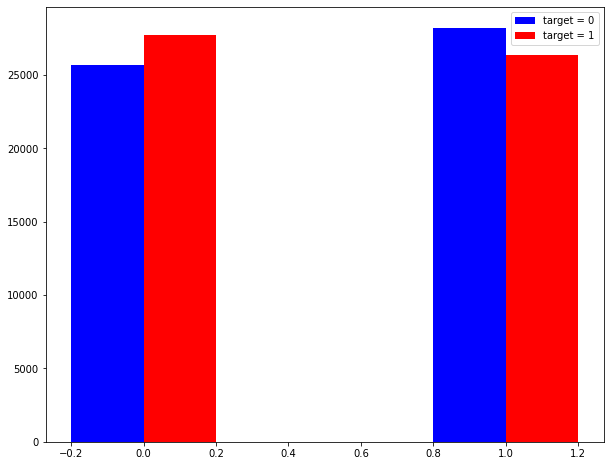

wasserstein distance:  0.036758328067145074


In [52]:
view_distribution_feature(eur_usd, 'discrete_ema_12', display_counts=True)

Para el caso de la media movil exponencial de 12 periodos respecto al precio, vemos un escenario similar. Cuando el precio de cierre se encuentra por debajo de la media, tenemos una mayor cantidad de targets 1. Caso contrario para cuando el precio se encuentra por encima.

,discrete_ema_26,target,count
0,0,0,26090
1,0,1,27627
2,1,0,27801
3,1,1,26463


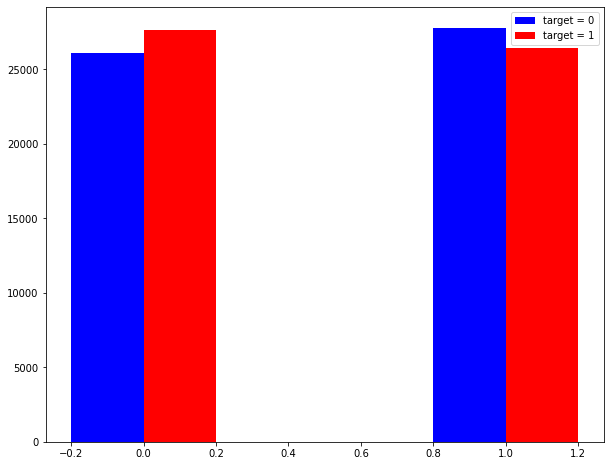

wasserstein distance:  0.02663448054228068


In [53]:
view_distribution_feature(eur_usd, 'discrete_ema_26', display_counts=True)

Para el caso de la ema de 26 periodos respecto al precio vemos el mismo comportamiento que para la de 12

,discrete_ema12_ema26,target,count
0,0,0,26316
1,0,1,27216
2,1,0,27575
3,1,1,26874


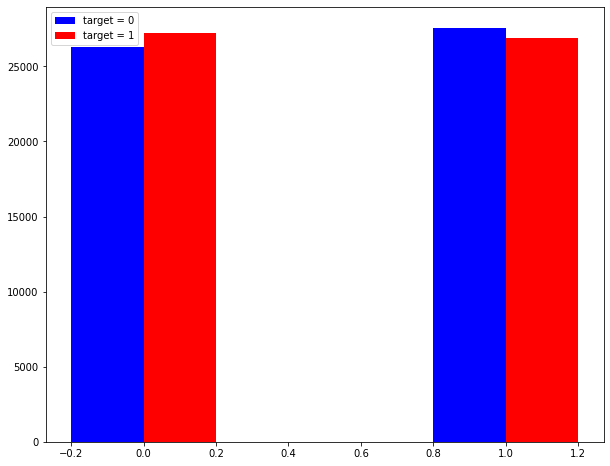

wasserstein distance:  0.014842383363893097


In [54]:
view_distribution_feature(eur_usd, 'discrete_ema12_ema26', display_counts=True)

Asi mismo, vemos que cuando la ema de 26 periodos se encuentra por encima de la ema de 12 periodos tenemos mas cantidad de velas alcistas que cuando sucede lo contrario.

### Bollinger Bands

,discrete_bollinger_bands,target,count
0,-1,0,3481
1,-1,1,3968
2,0,0,46409
3,0,1,46522
4,1,0,4001
5,1,1,3600


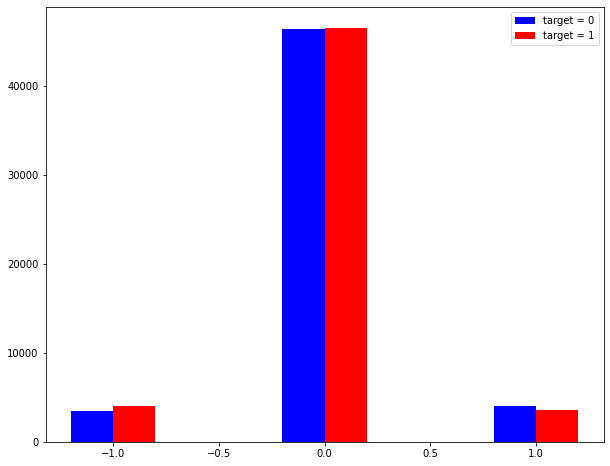

wasserstein distance:  0.016452582218514228


In [55]:
view_distribution_feature(eur_usd, 'discrete_bollinger_bands', display_counts=True)

### MACD

,discrete_macd_signal,target,count
0,0,0,26338
1,0,1,27123
2,1,0,27553
3,1,1,26967


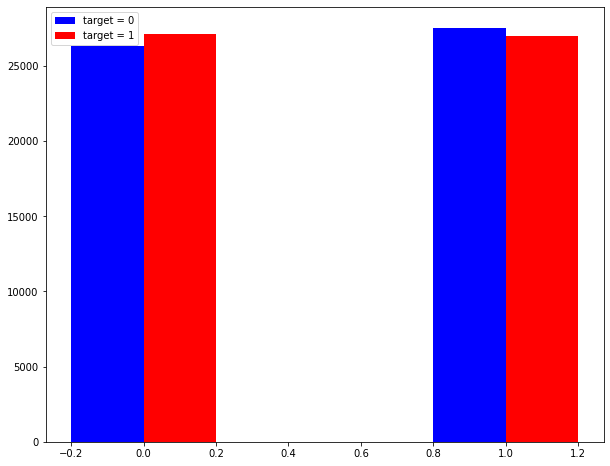

wasserstein distance:  0.012714795305941662


In [56]:
view_distribution_feature(eur_usd, 'discrete_macd_signal', display_counts=True)

,discrete_macd_hist,target,count
0,0,0,26404
1,0,1,27179
2,1,0,27487
3,1,1,26911


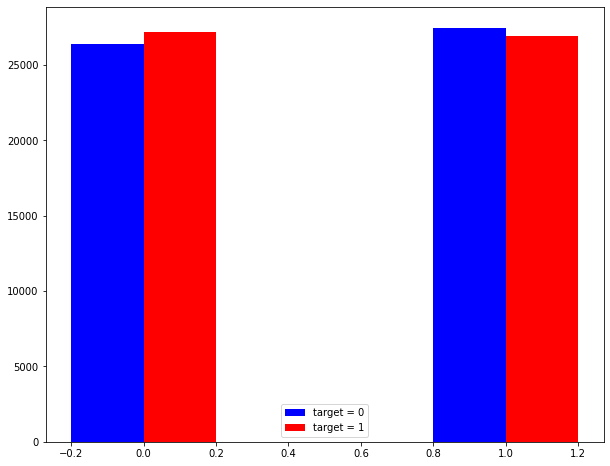

wasserstein distance:  0.012525412533455516


In [57]:
view_distribution_feature(eur_usd, 'discrete_macd_hist', display_counts=True)

,discrete_macd_signal_hist,target,count
0,0,0,26619
1,0,1,26923
2,1,0,27272
3,1,1,27167


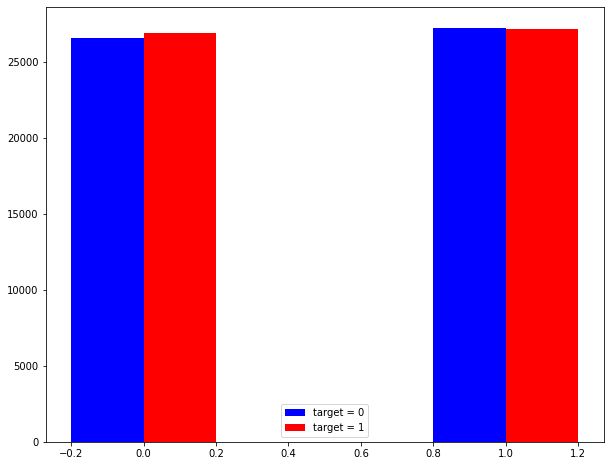

wasserstein distance:  0.0038030254498598315


In [58]:
view_distribution_feature(eur_usd, 'discrete_macd_signal_hist', display_counts=True)

### Stochastic

,discrete_stochastic,target,count
0,1,0,695
1,1,1,758
2,2,0,2556
3,2,1,2702
4,3,0,4825
5,3,1,5169
6,4,0,7632
7,4,1,8210
8,5,0,10356
9,5,1,10792


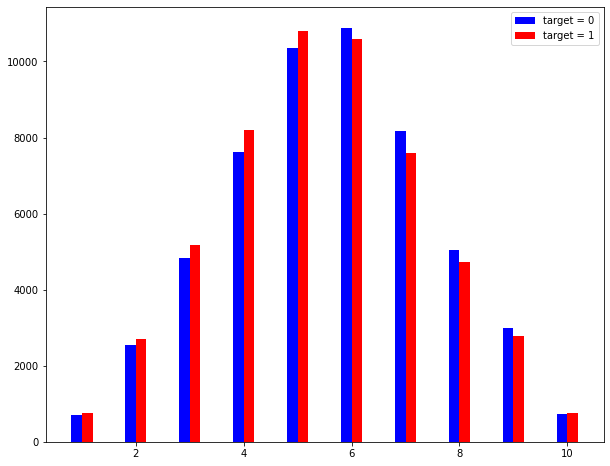

wasserstein distance:  0.09625342944607501


In [59]:
view_distribution_feature(eur_usd, 'discrete_stochastic', display_counts=True)

,discrete_kd,target,count
0,0,0,26184
1,0,1,27748
2,1,0,27707
3,1,1,26342


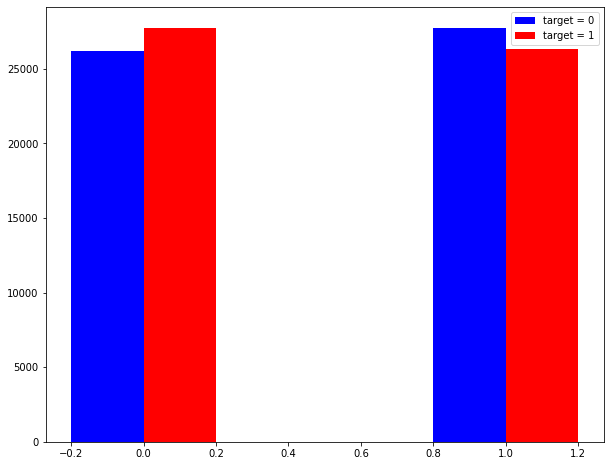

wasserstein distance:  0.027127231364032667


In [60]:
view_distribution_feature(eur_usd, 'discrete_kd', display_counts=True)

In [61]:
from matplotlib.pyplot import figure

In [67]:
def get_evolution_feature(dataframe, target, features_analyze, max_periods_fordward):
    
    df = dataframe.copy()
    
    target_columns = []
    for x in range(1, max_periods_fordward + 1):
        new_column = target + '_shifted_' + str(x)
        df[new_column] = create_target(df.close, x)
        target_columns.append(new_column)
    
    for feature in features_analyze:
        
        print(feature)
        
        bearish_mean_evolution = np.array([])
        bullish_mean_evolution = np.array([])

        bearish_std_evolution = np.array([])
        bullish_std_evolution = np.array([])
        
        wassertein_distance_evolution = np.array([])

        for target_column in target_columns:
            
            df_bearish = df.loc[df[target_column] == 0]
            df_bullish = df.loc[df[target_column] == 1]
            
            dist = wasserstein_distance(df_bearish[feature], df_bullish[feature])
            wassertein_distance_evolution = np.append(wassertein_distance_evolution, dist)

            group_by_target = df.groupby(target_column)

            mean = group_by_target[feature].mean()
            std = group_by_target[feature].std()
            
            bearish_mean_evolution = np.append(bearish_mean_evolution, mean[0])
            bearish_std_evolution = np.append(bearish_std_evolution, std[0])

            bullish_mean_evolution = np.append(bullish_mean_evolution, mean[1])
            bullish_std_evolution = np.append(bullish_std_evolution, std[1])
            
        plt.figure(figsize=(25,10))
        plt.subplot(2, 1, 1)
        plt.plot(bullish_mean_evolution, c='g',label = 'Mean target up ' + feature)
        plt.plot(bullish_mean_evolution+1*bullish_std_evolution, linestyle='--', c='limegreen', label = '+1 std' + feature)
        plt.plot(bullish_mean_evolution-1*bullish_std_evolution, linestyle='--', c='limegreen',label = '-1 std' + feature)

        plt.plot(bearish_mean_evolution, c='r',label = 'mean target down ' + feature)
        plt.plot(bearish_mean_evolution+1*bearish_std_evolution, linestyle='--', c='orangered', label = '+1 std' + feature)
        plt.plot(bearish_mean_evolution-1*bearish_std_evolution, linestyle='--', c='orangered',label = '-1 std' + feature)
        plt.title(feature + ' evolution in ' + str(max_periods_fordward) + ' periods')

        plt.subplot(2, 1, 2)
        plt.plot(range(0, len(wassertein_distance_evolution)), wassertein_distance_evolution)
        plt.title('Wassertein distance evolution')
        
        #plt.plot(bullish_std_evolution, label = 'Std target up ' + feature)
        #plt.plot(bearish_std_evolution, label = 'Std target down ' + feature)
        #plt.title('Close price of EURUSD')
        #plt.legend(loc='best')
        plt.show()

rsi


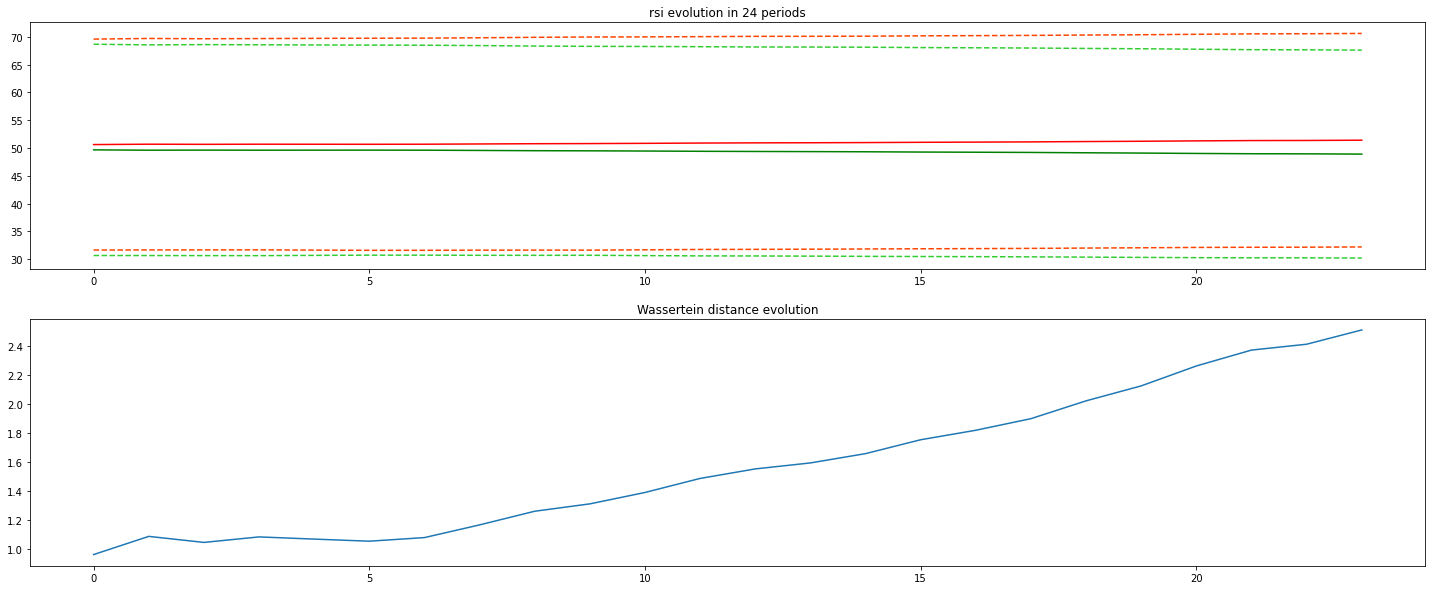

ema_12


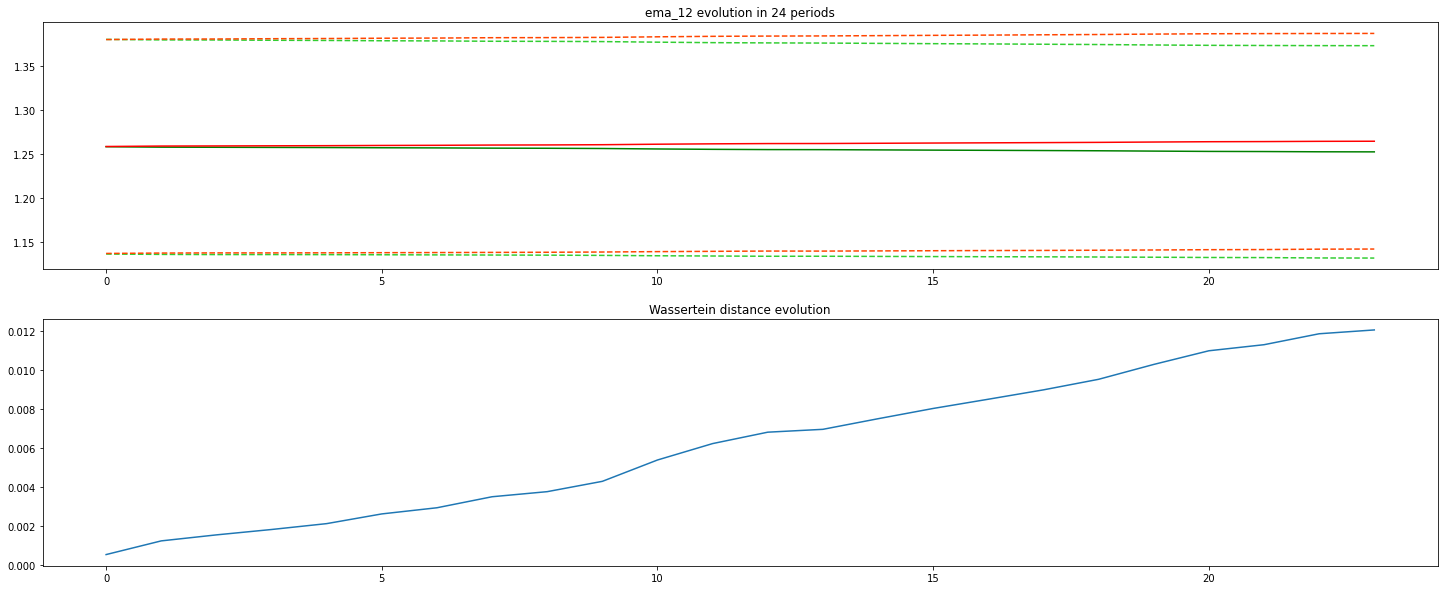

discrete_ema_12


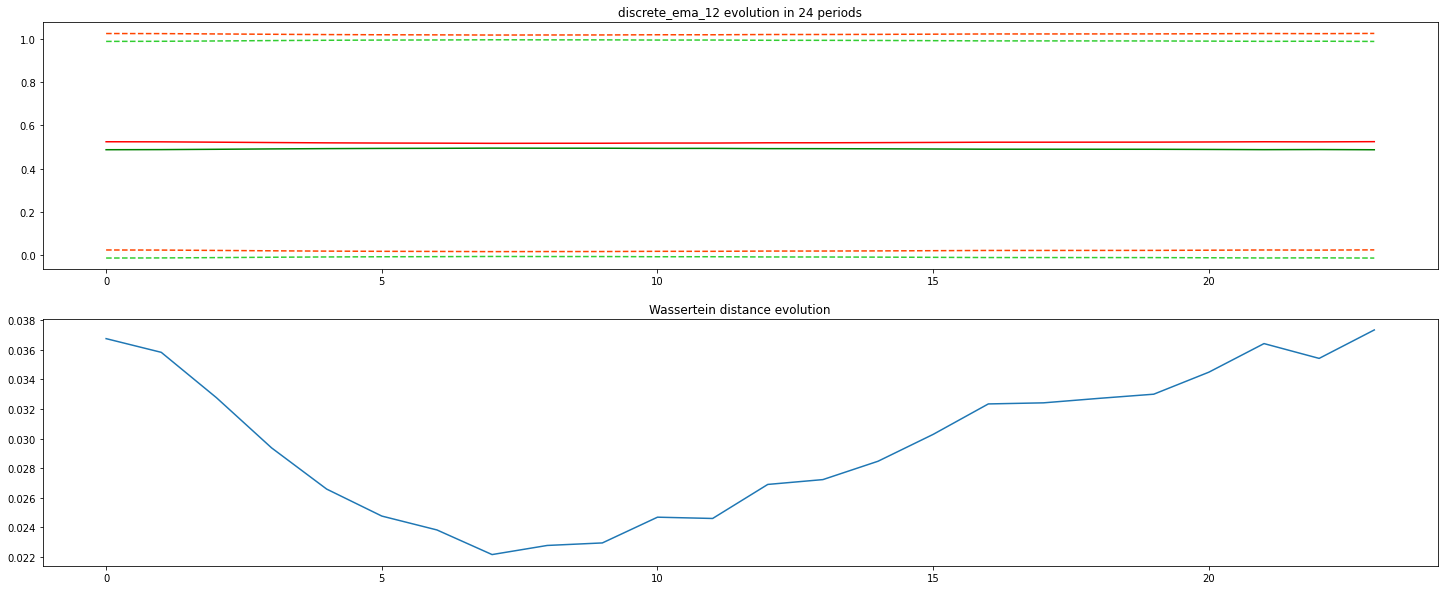

ema_26


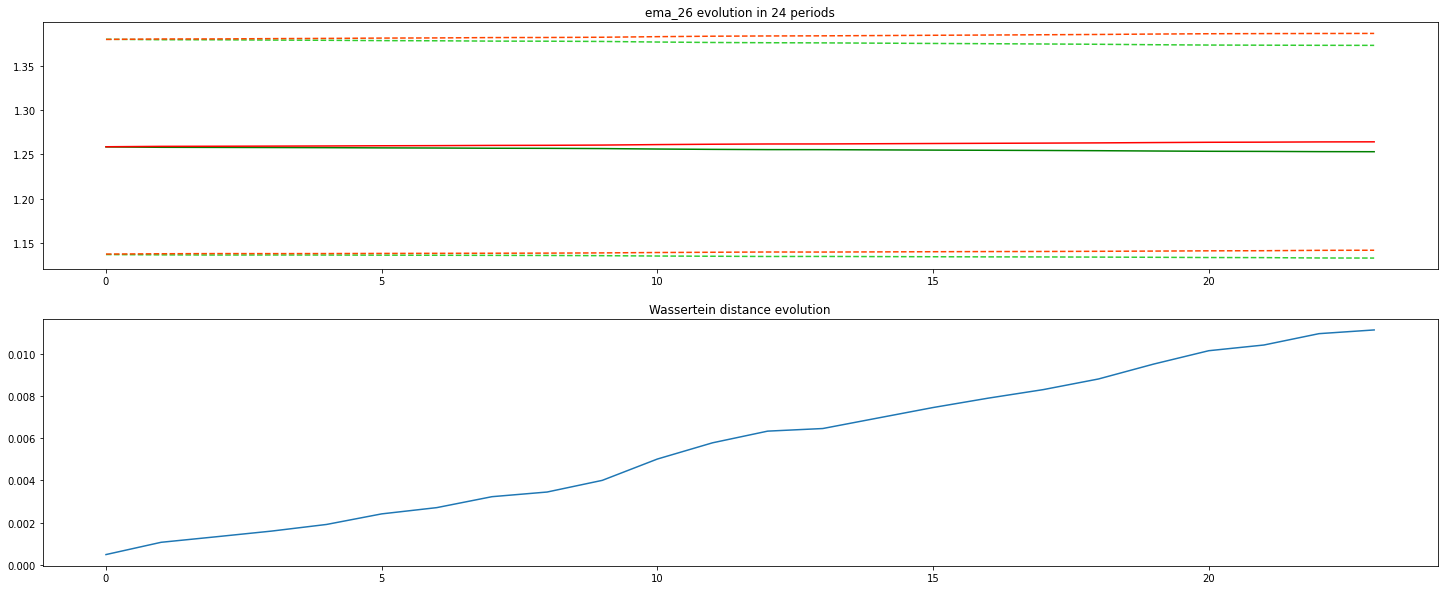

discrete_ema_26


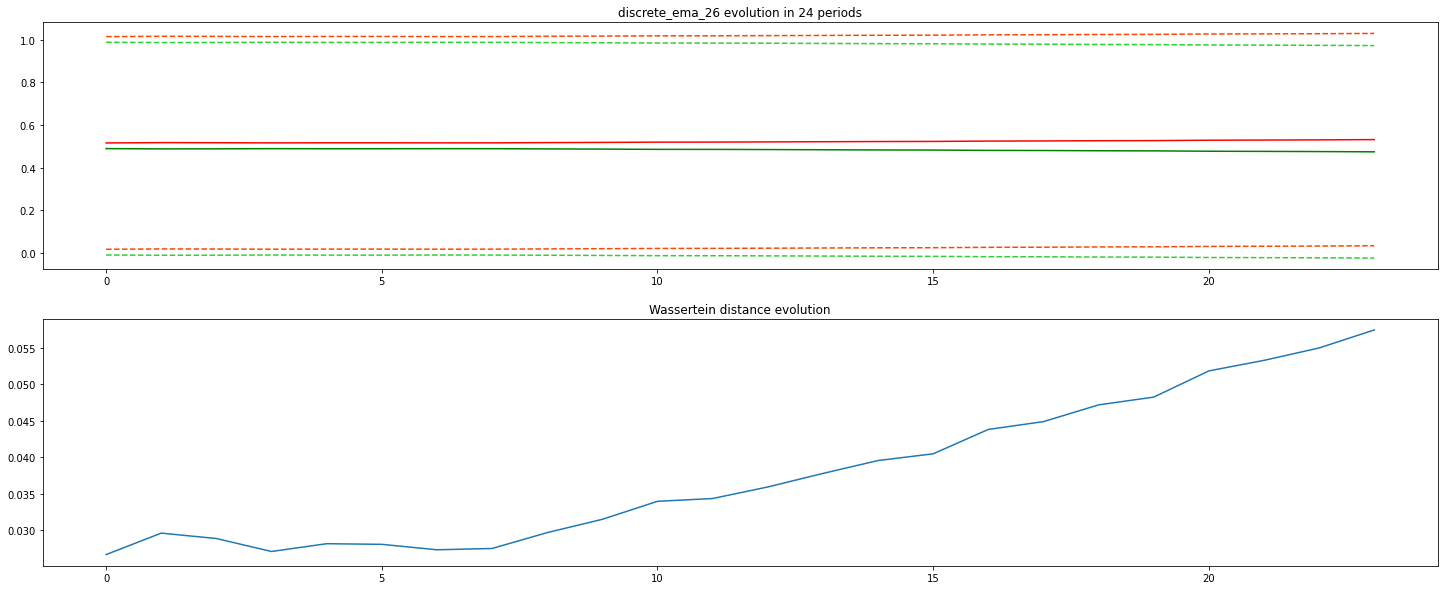

discrete_ema12_ema26


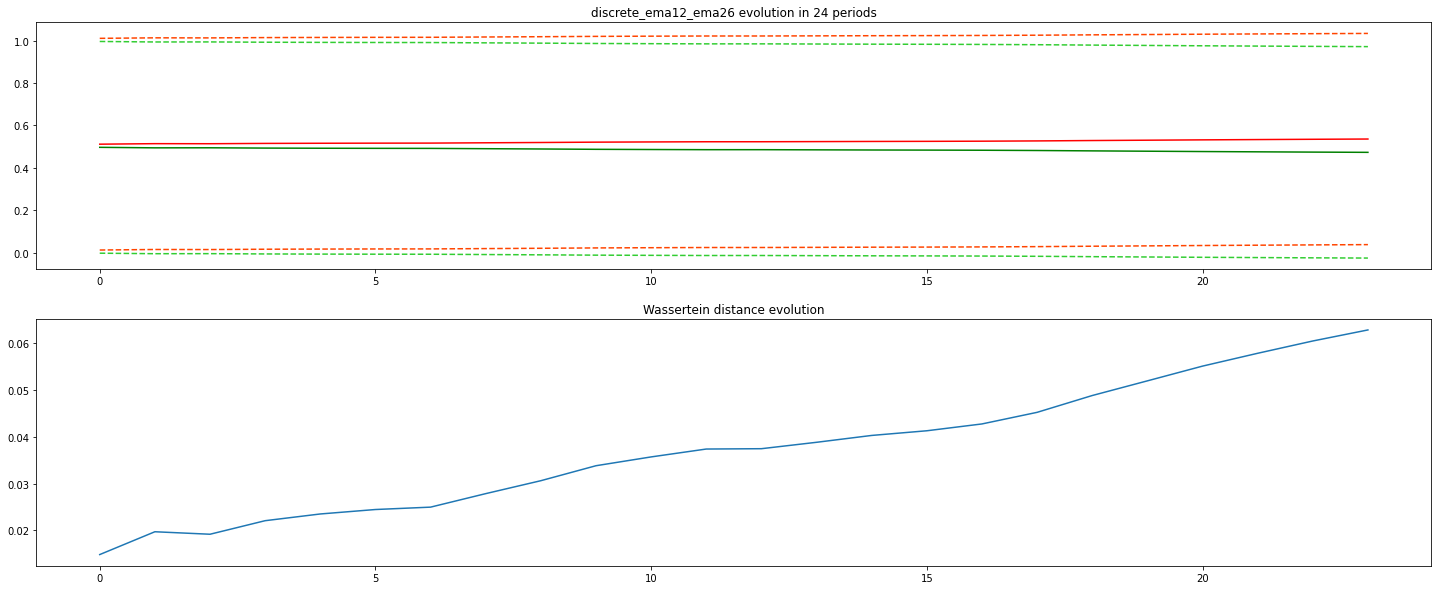

upper_bband


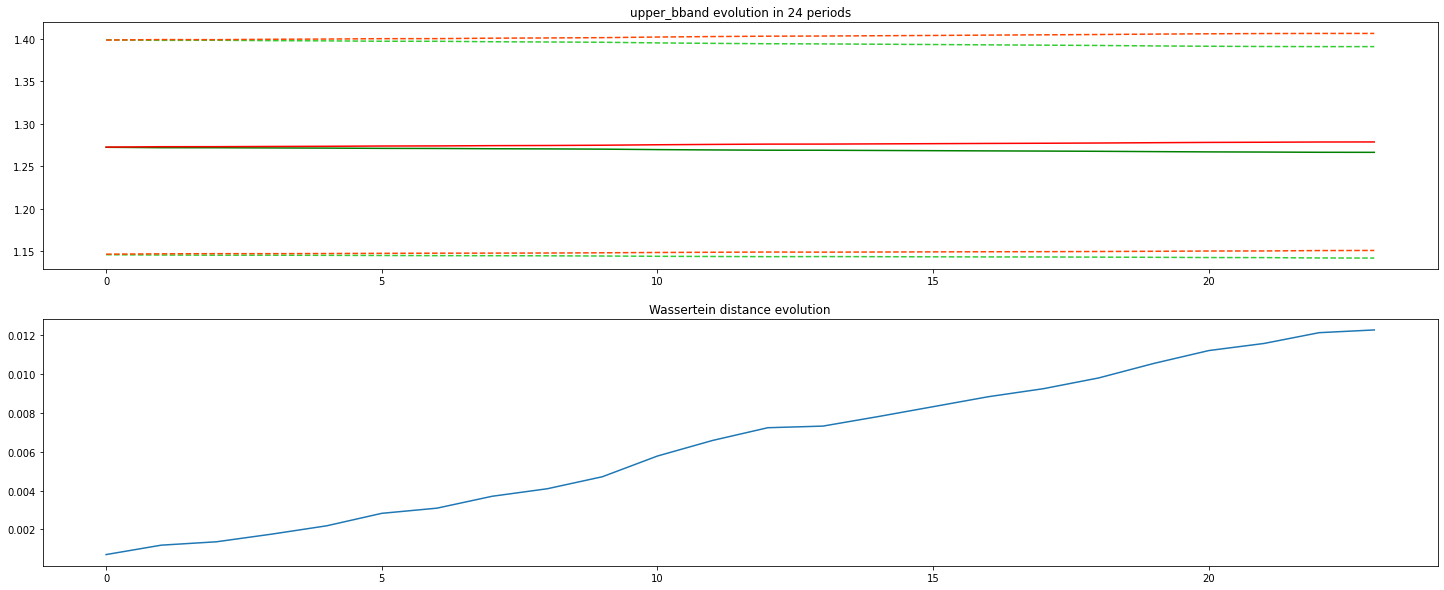

middle_bband


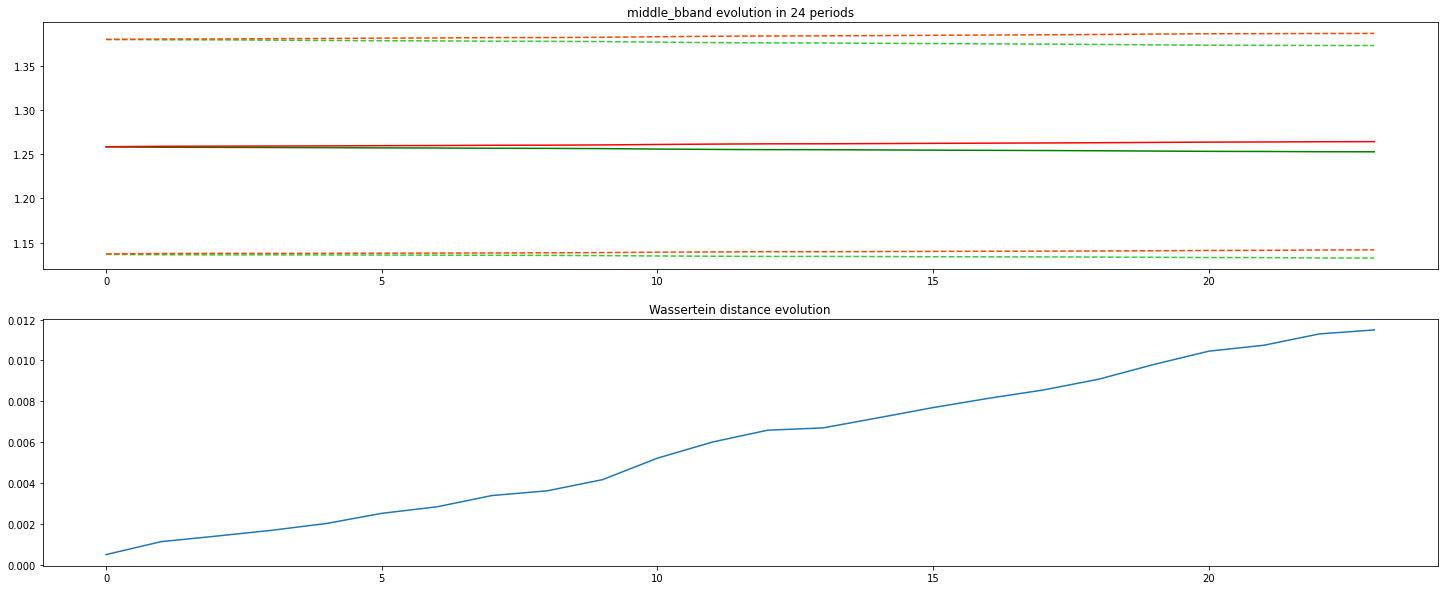

lower_bband


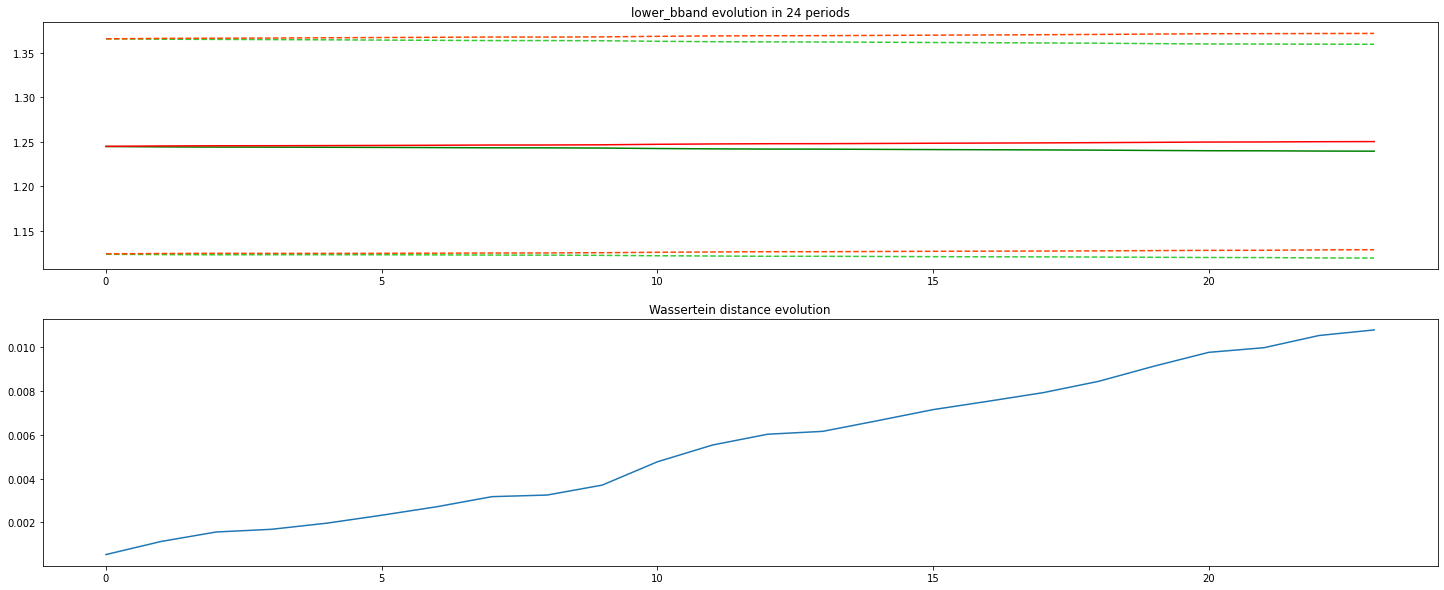

discrete_bollinger_bands


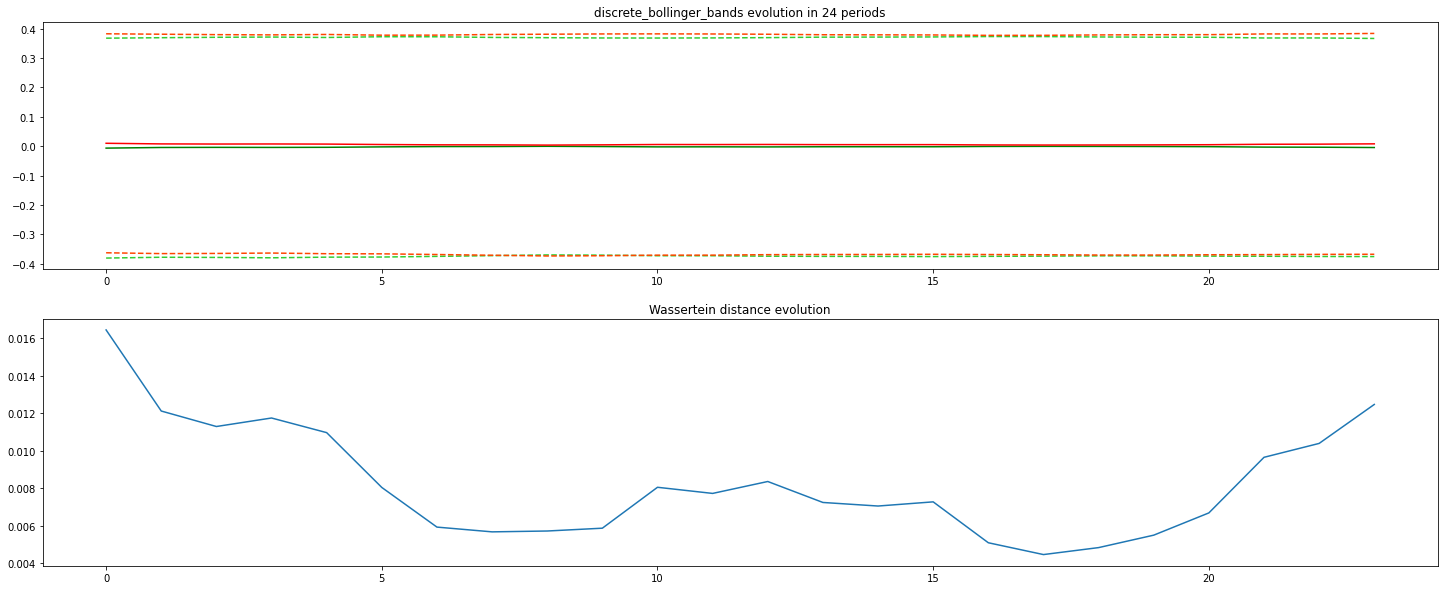

b_percentage


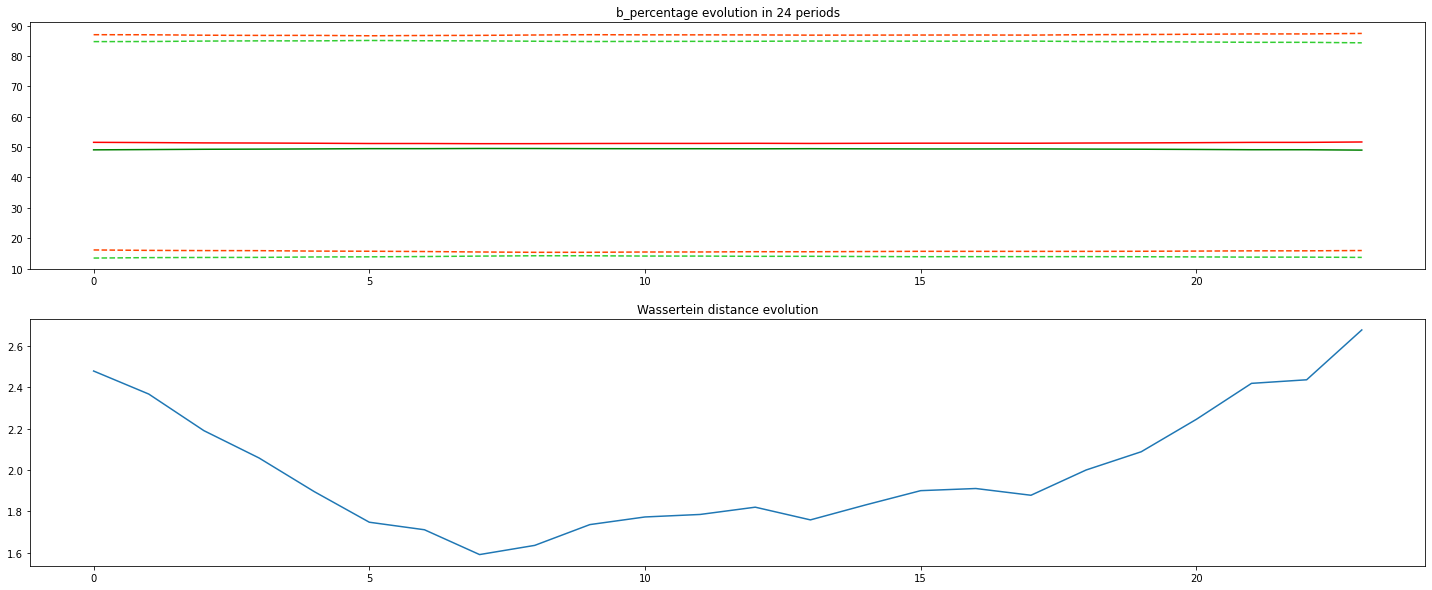

macd


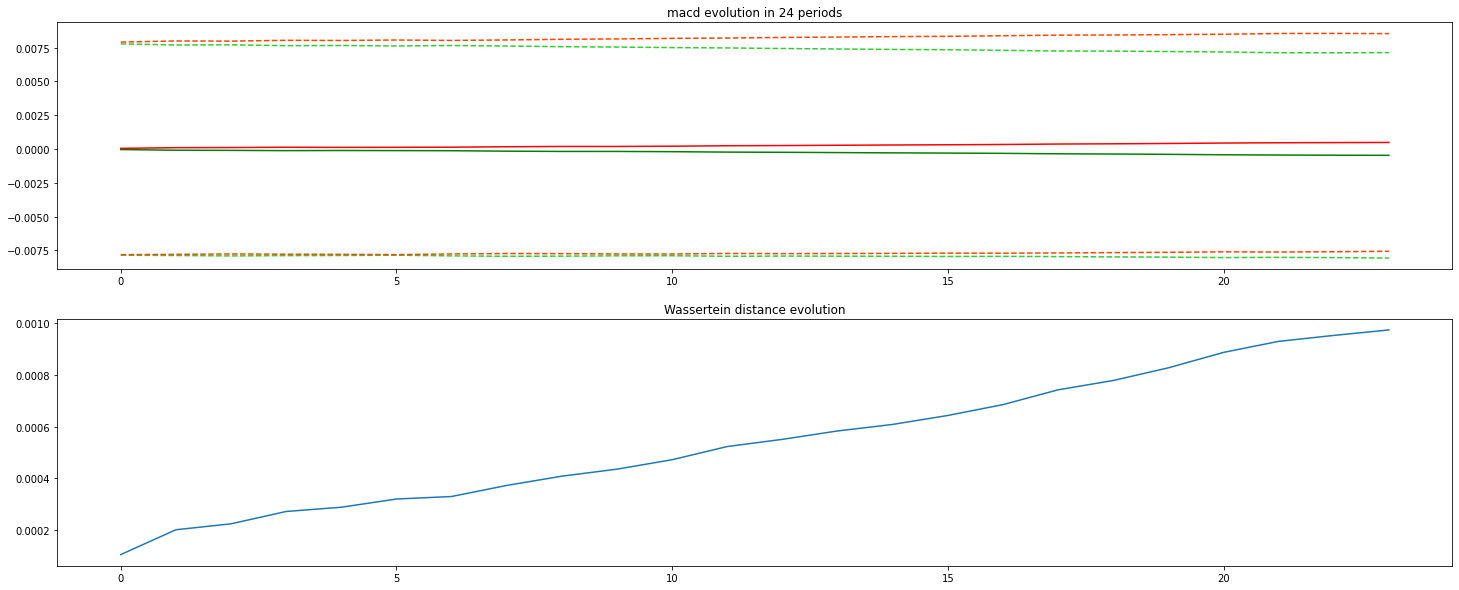

macd_signal


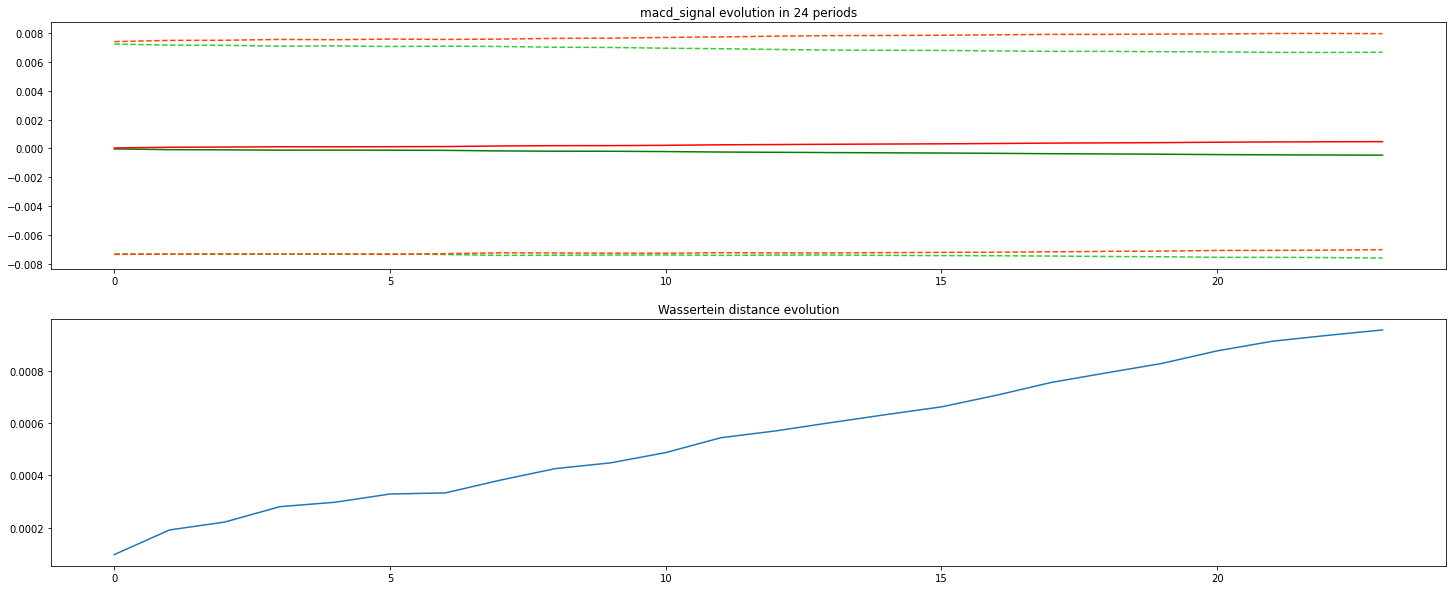

discrete_macd_signal


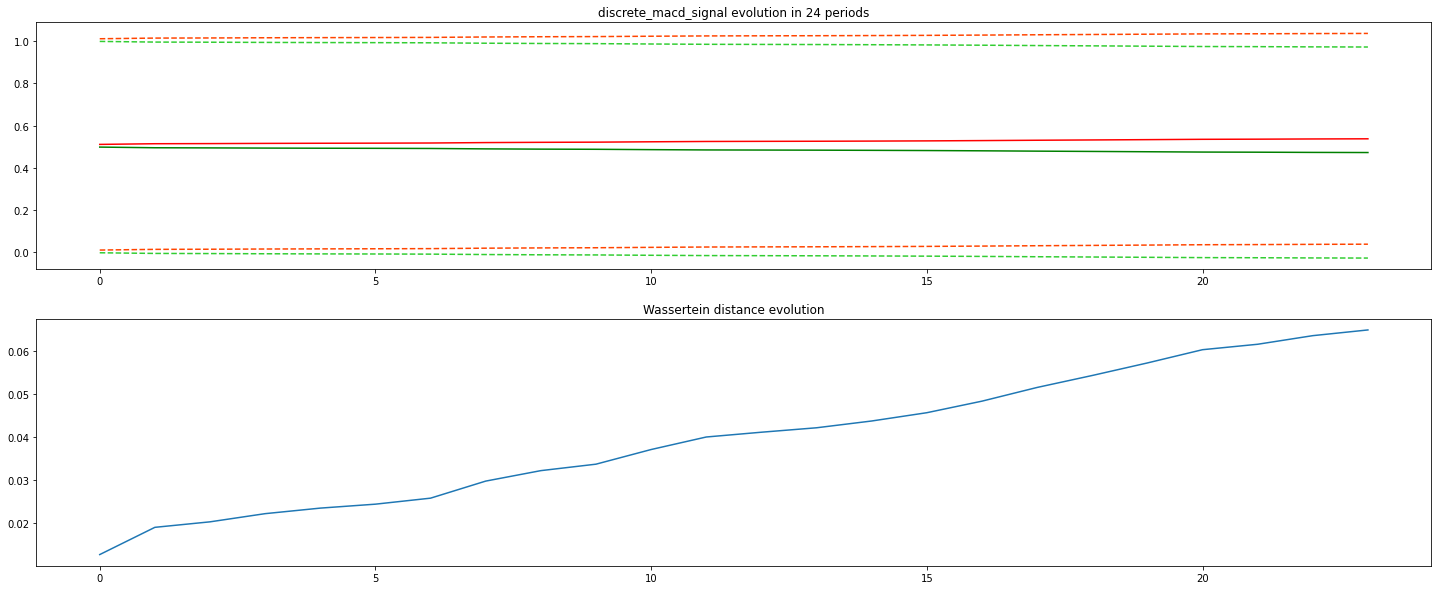

macd_hist


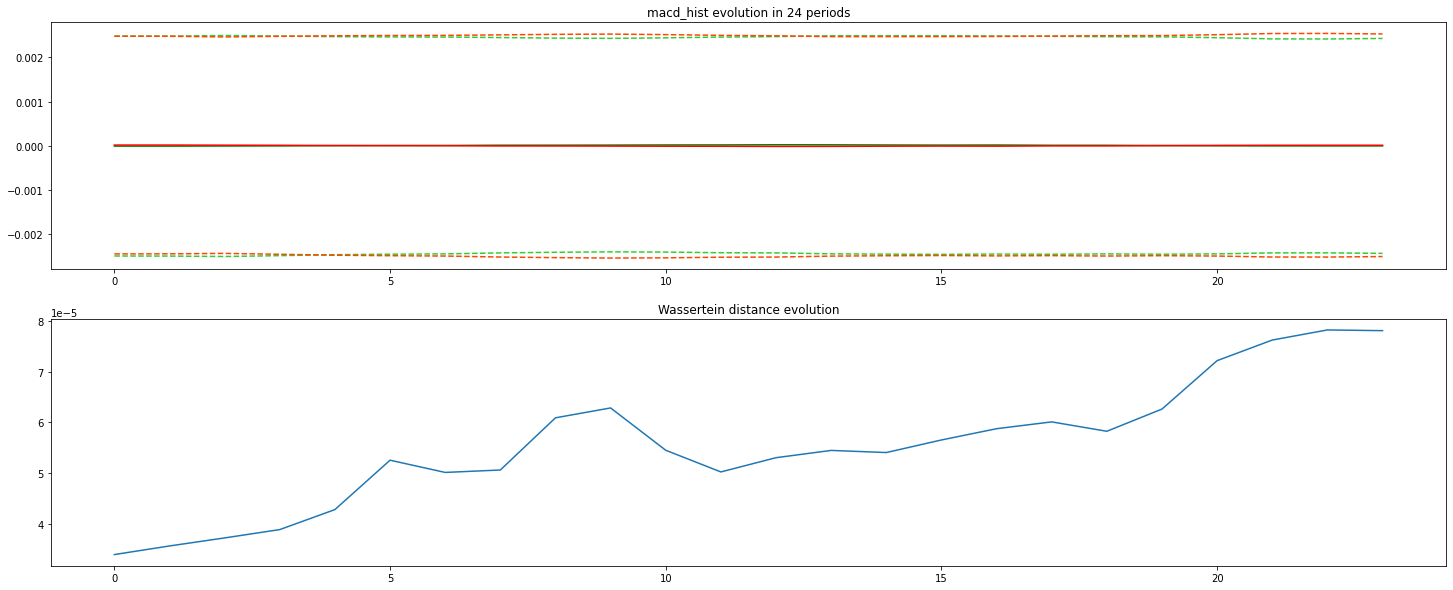

discrete_macd_hist


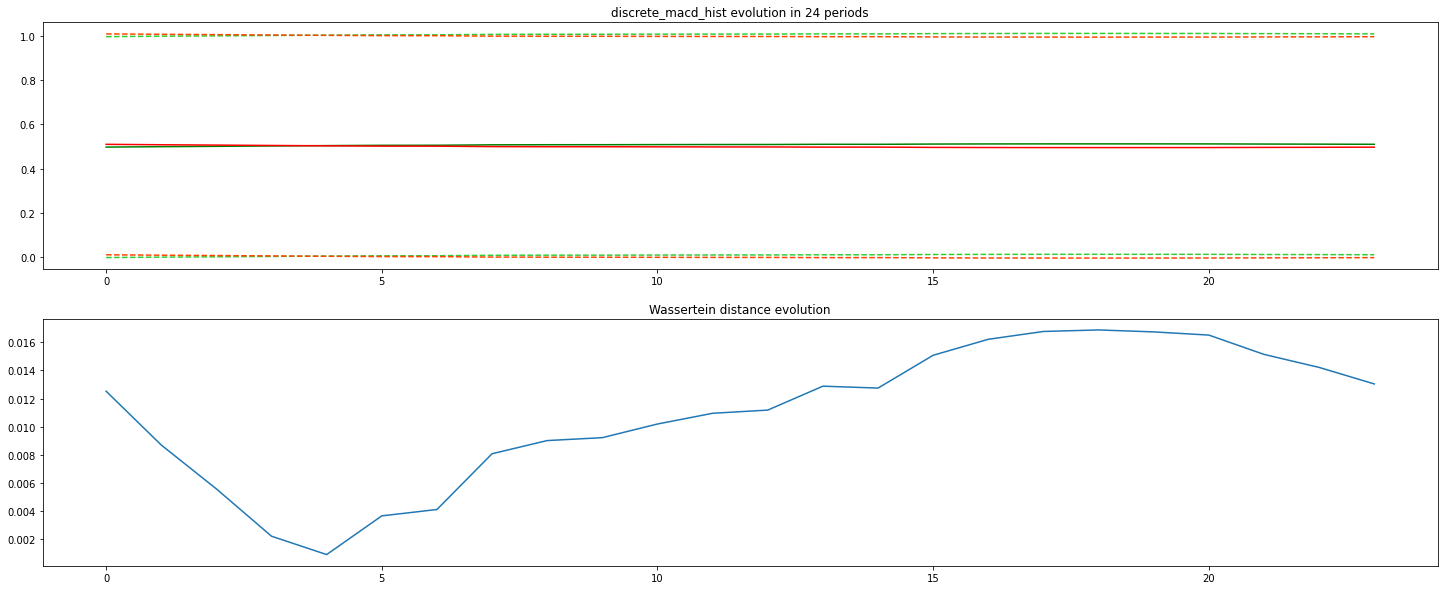

discrete_macd_signal_hist


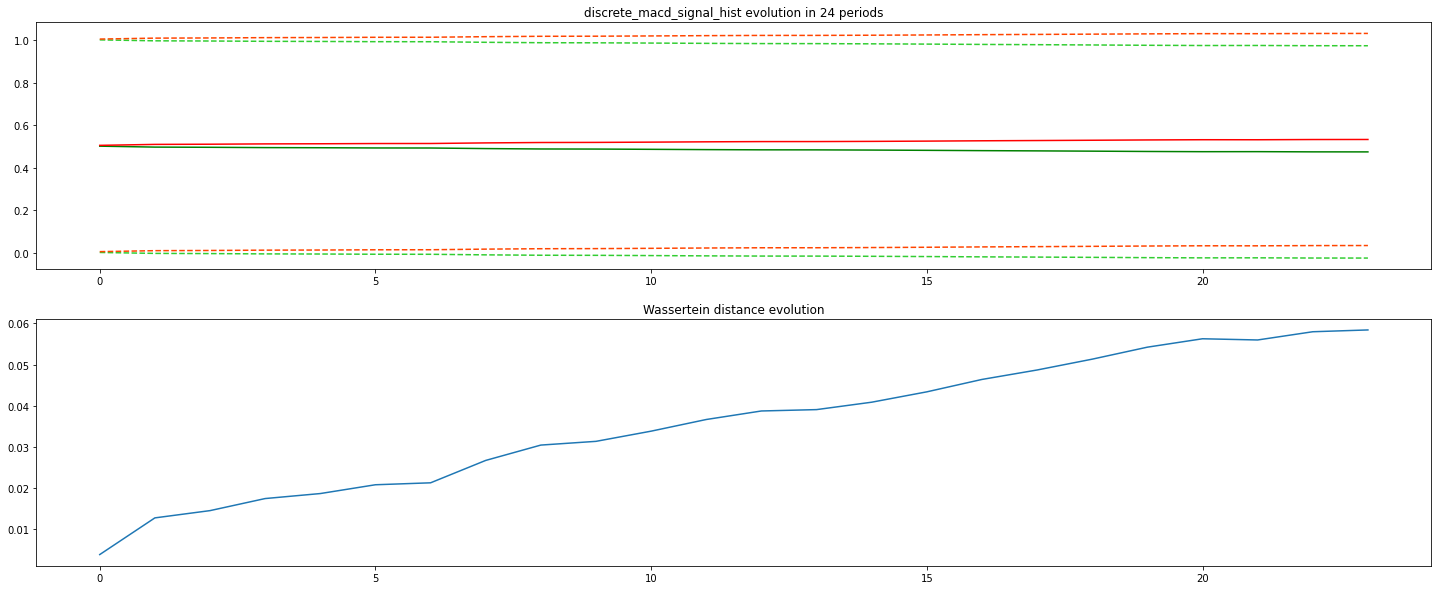

k


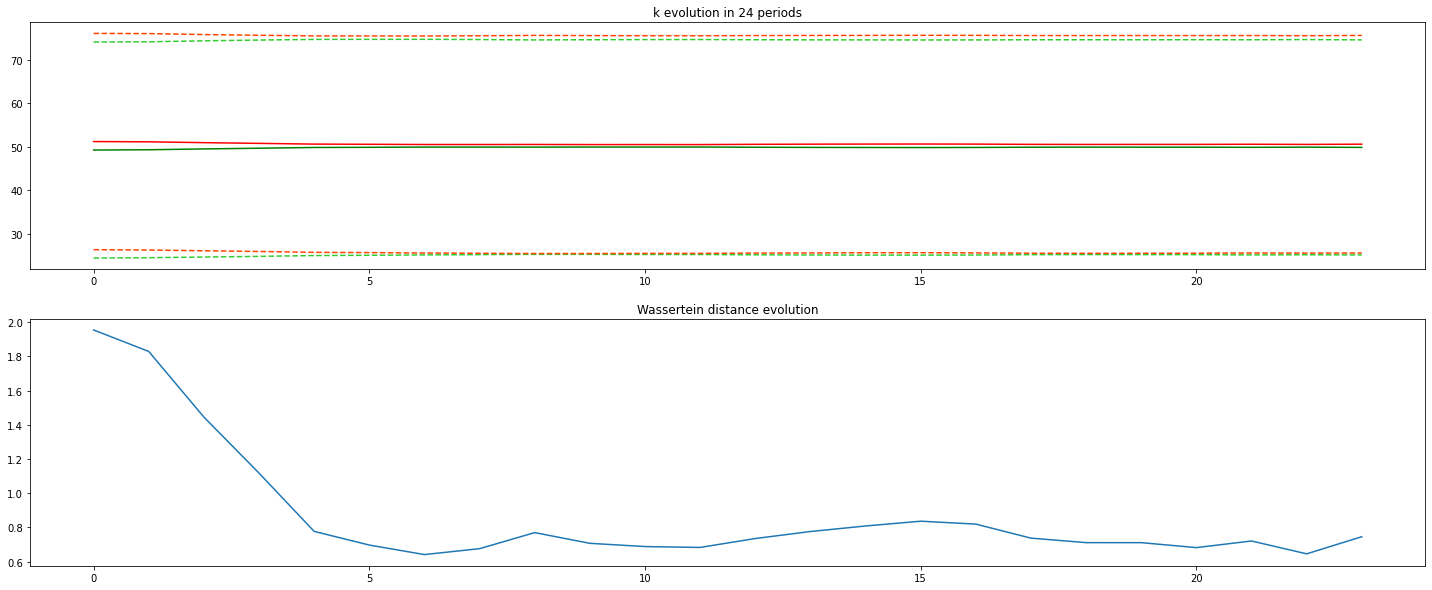

d


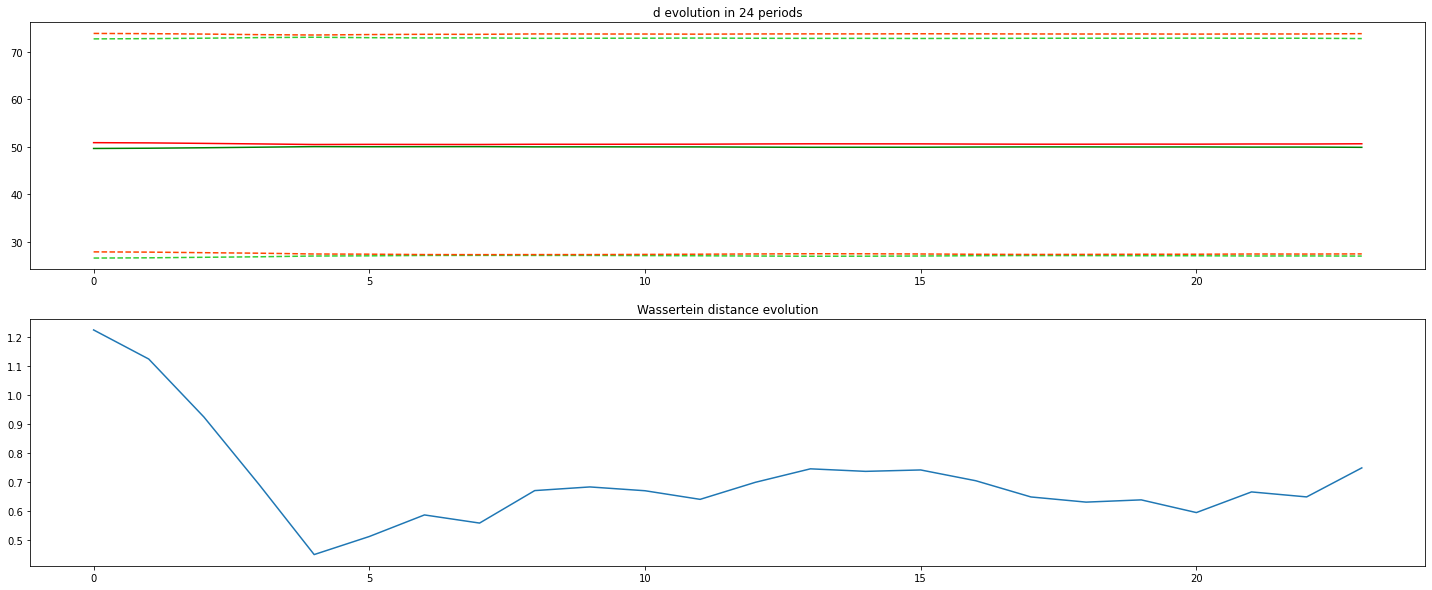

discrete_kd


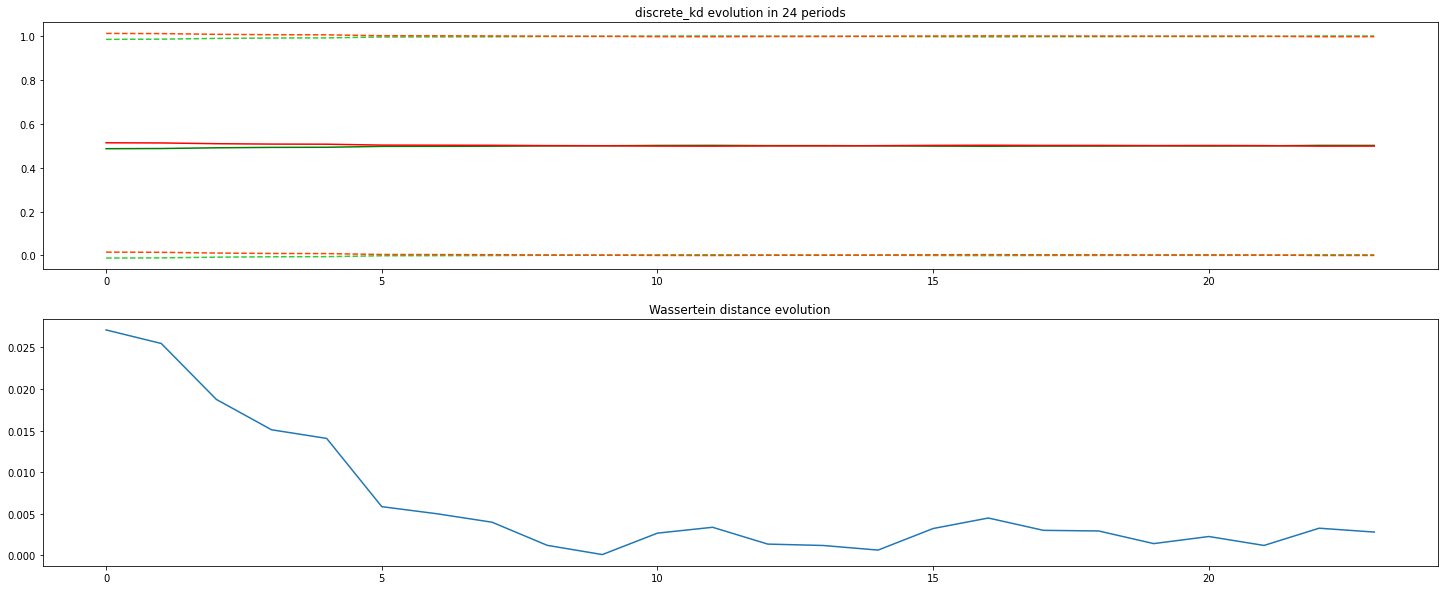

In [70]:
cols = ['rsi','ema_12', 'discrete_ema_12','ema_26', 'discrete_ema_26', 'discrete_ema12_ema26','upper_bband', 'middle_bband', 'lower_bband',
        'discrete_bollinger_bands', 'b_percentage', 'macd', 'macd_signal', 'discrete_macd_signal', 
        'macd_hist', 'discrete_macd_hist', 'discrete_macd_signal_hist','k', 'd', 'discrete_kd'] 

get_evolution_feature(eur_usd, 'target', cols, 24)